### Term Counting Approach

In [1]:
#if jupyternotify is installed, we can add %notify to a cell to get an alert when it ifnished running
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
import metrics_helpers as indicators
import pickle as pk
import gc
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import traceback #needed to store full error tracebacks

In [3]:
def dt_to_int(dt): #datetime to integer
    return dt.astype('int')/(10**9)

#### Load Data and Prepare Functions

In [4]:
with open('/Users/sma/Documents/INRAE internship/scrape-git/facebook/untypod_dict.pkl', 'rb') as f:
    netmums = pk.load(f)

#with open('/Users/sma/Documents/INRAE internship/scrape-git/netmums/allposts_rerun.pkl', 'rb') as f:
#    netmums = pk.load(f)
    
#with open('/Users/sma/Documents/INRAE internship/scrape-git/netmums/netmums_subset_keys.txt', 'r') as f:
#    keys = [url.strip() for url in f.readlines()]
        

In [5]:
nm_ind = indicators.indicators(netmums, fb=False)
#this one takes long, around 20 seconds I think.

posts_dict = nm_ind.get_posts_dict()

In [6]:
hazards = {
'Chemical contaminants': [],
'Endocrine disruptor': ["endocrine","estrogen"],
'FOOD PRESERVATIVES, SWEETENERS AND ADDITIVES':["preservatives","sweeteners","additives"],
"Pesticides":[],
"Veterinary drugs":["animal drugs","vet drugs"],
'GMO':['GM',"genetically modified"],
"Metals":[],
"Mycotoxin":[],
"Bisphenol A":['BPA','Bisphenol','BisphenolA'],
'Furan':[],
'DON': #(note that this acronym nobody uses and all results are from words like "don't")
["deoxynivalenol",
"vomitoxin"],
'DIOXIN AND PCB':["Dioxin","PCB","biphenyls"],
'MOSH and MOAH':["hydrocarbons","saturated hydrocarbons","MOAH", 'MOH',"aromatic hydrocarbons"],
'Nitrates':[],
"Acrylamid":["Acrylamide"],
"phthalates":[],
"Microbiologic contaminants":
["spores",
"mold",
"mould",
#"virus",
"microbes",
"contaminated"],
"Salmonella":[],
"Campylobacter":[],
"Listeria":[],
"EColi":["E-coli"],
"Cronobacter":[],
"Histamine":[],
'other bacteria':["bacteria"],
"Virus":[],
"Parasites":[],
'Related Terms':["carcinogen","chemicals", "toxic", "toxin", "poisonous", "fungus", "food poisoning", "hazard","EFSA","European Food Safety Authority"]
}

products = {
'infant formula':
["formula","baby formula", "bottle-fed", "bottle"]
,'sterilized vegetable mixed with fish':
["veggie baby food","vegetable baby food",
"veg puree", "veg purée"]
,'fresh fruit puree mildly processed':
["fruit puree","fruit baby food", "fruit purée", "applesauce", "apple sauce", "fruit sauce"]
,'infant cereals':
["cereal for baby", "cereal", "porridge", "oats", "oatmeal"]
,'other':
["jar food", "baby food", "jarred", "premade food", "puree", "purée", "jarred food"
,"yoghurt", "pudding"]
}


#IMPORTANT!: terms used for count vectorizer must be lower-case o.w. get 0 matches
hazards = {key.lower():[v.lower() for v in value] + [key.lower()] for key,value in hazards.items()}
products = {key.lower():[v.lower() for v in value]+[key.lower()] for key,value in products.items()}

In [7]:

extras = {\
'baby_food_brands':
['ellas',
'organix',
'heinz baby',
"plum baby",
'little angels',
'farleys'],
'formula_brands':['sma','aptamil comfort','infasoy','nutramigen','neocate','powdered milk','comfort milk'],
 'food_or_formula_brands':
['aptamil', # formula and cereals.
'hipp organic',# - formula and baby food
'cow gate','cow and gate','c g',
'mamia'],
##NON BRAND SIGNALS##
'cereal':['baby_cereal','baby riceporridge','baby rice','baby porridge'],
'baby_food':['mashed','tinned','premade','canned','jarred','pouches','pouch','ready made','readymade','cartons'],  
#INDICATORS TO BE USED IN CONJUNCTION WITH 'baby food' label: this way we 
#can observe if both terms are used in a document (but are not used right next to each other.)
'fruit':['fruit'],
'vegetable':['vegetable'],
'baby':['infant', 'baby' ,'for littles']
         }


In [8]:
import re

def make_phrases(list_of_phrases, text):
    """
    convert phrases to bigrams within a larger text corpus.
    example: "I love collard greens for breakfast" -> "I love collard_greens for breakfast"
    example: "I love collard-greens for breakfast" -> "I love collard_greens for breakfast"
    """
    for phrase in list_of_phrases:
        #spaces
        text = re.sub(phrase, re.sub(' ', '_',phrase), text)
        #hyphens
        text = re.sub(re.sub(' ', '-', phrase), re.sub(' ', '_',phrase), text)
    return text

def make_underscores(item):
    """
    recursively replace spaces and hyphens in strings, lists, sets, or other iterables.
    Return the same type if string, list, set. If other type, returns list.
    """
    if type(item) is str:
        return re.sub(' |-', '_', item)
    else:
        temp = []
        for thing in item:
            temp.append(make_underscores(thing))
    if type(item) is set:
        return set(temp)
    elif type(item) is list:
        return temp
    elif isinstance(item, type({}.keys())):
        #if the object is a dict.key() view
        return temp
    else:
        print('Object must be string, list, set, or dict.keys()')
    #TODO this would be cleaner if i just check that it's iterable, and then check that it's a string.

In [9]:
#from the dict which representes our subcategories, create lists of all words in the subcategories.
h = [item for val in hazards.values() for item in val]
p = [item for val in products.values() for item in val]
e = [item for val in extras.values() for item in val]

#### Run Vectorizers

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#concatenate list of all phrases (bigrams, anything with a space in it)
phrases = {'baby formula', 'baby cereal'}.union({item for item in p + h + e if ' ' in item})

#step 1: make a dict of just the text
text_dict = {key:value['body'] for key,value in posts_dict.items()}

#step 2 : convert the relevant phrases to bigrams with re.sub
text_dict = {key: make_phrases(phrases, text) for key, text in text_dict.items()}

#replace "don't" with "do not" (so that we don't get false positives for don count.)
for key in text_dict:
    text_dict[key] = re.sub('don[\W]+t', 'do not', text_dict[key], flags=re.I) #TODO. there are cases of "don' " need to catch.

#step 3: count occurences using countvectorizer
vocab = p + h + e
vocab = [re.sub(' |-','_',item) for item in vocab] #should I use make_underscores instead??
vocab = set(vocab) #remove duplicates
term_counter = CountVectorizer(vocabulary = vocab, stop_words = 'english')
counts = term_counter.fit_transform(text_dict.values())

#step4: take a sample of other words, we can use this as control and check for correlations with our terms.
size_of_these_vec = 100
all_term_counter_max = CountVectorizer(stop_words = 'english', max_features= size_of_these_vec)
    #limit to terms with certain tf-idf count
all_term_counter_maxdf = CountVectorizer(stop_words = 'english', max_features= size_of_these_vec, max_df = 0.03)

max_counts = all_term_counter_max.fit_transform(text_dict.values())
maxdf_counts = all_term_counter_maxdf.fit_transform(text_dict.values())

#note that hyphens will be treated as spaces by countvectorizer

In [139]:
#DEBUG
nolimit = CountVectorizer(stop_words = 'english')
testc = nolimit.fit_transform(text_dict.values())

In [142]:
len(nolimit.vocabulary_.items())

26560

In [11]:
def dict_from_arr(counts, counter):
    if type(counts) is not np.ndarray:
        counts = counts.toarray() #convert from sparse array to np array if it hasn't already.
    count_dict = {}    #initialize dict
    for num, key in enumerate(text_dict.keys()): #TODO just use netmums, not text_dict?? its confusing. (they have the same keys)
        count_dict[key] = {term: counts[num][value] for term, value in counter.vocabulary_.items()}
    return count_dict

In [12]:
countdf = pd.DataFrame.from_dict(dict_from_arr(counts, term_counter)).transpose()
countdf

acrylamid  acrylamide  \
https://www.netmums.com/coffeehouse/becoming-mu... 0          0           0   
                                                   1          0           0   
                                                   2          0           0   
                                                   3          0           0   
                                                   4          0           0   
...                                                         ...         ...   
https://www.netmums.com/coffeehouse/being-mum-7... 5          0           0   
                                                   6          0           0   
                                                   7          0           0   
                                                   8          0           0   
                                                   9          0           0   

                                                      additives  animal_drugs  \
https://www.netmums.com/coffeehouse/becoming-mu... 0          0             0   
                                                   1          0             0   
                                                   2          0             0   
                                                   3          0             0   
                                                   4          0             0   
...                                                         ...           ...   
https://www.netmums.com/coffeehouse/being-mum-7... 5          0             0   
                                                   6          0             0   
                                                   7          0             0   
                                                   8          0             0   
                                                   9          0             0   

                                                      apple_sauce  applesauce  \
https://www.netmums.com/coffeehouse/becoming-mu... 0            0           0   
                                                   1            0           0   
                                                   2            0           0   
                                                   3            0           0   
                                                   4            0           0   
...                                                           ...         ...   
https://www.netmums.com/coffeehouse/being-mum-7... 5            0           0   
                                                   6            0           0   
                                                   7            0           0   
                                                   8            0           0   
                                                   9            0           0   

                                                      aptamil  \
https://www.netmums.com/coffeehouse/becoming-mu... 0        0   
                                                   1        0   
                                                   2        0   
                                                   3        0   
                                                   4        0   
...                                                       ...   
https://www.netmums.com/coffeehouse/being-mum-7... 5        0   
                                                   6        0   
                                                   7        0   
                                                   8        0   
                                                   9        0   

                                                      aptamil_comfort  \
https://www.netmums.com/coffeehouse/becoming-mu... 0                0   
                                                   1                0   
                                                   2                0   
                                                   3                0   
             

In [13]:
maxcountdf = pd.DataFrame.from_dict(dict_from_arr(max_counts, all_term_counter_max)).transpose()

In [14]:
maxdfcountdf = pd.DataFrame.from_dict(dict_from_arr(maxdf_counts, all_term_counter_maxdf)).transpose()

#### Meta: Check if our groupings of hazard terms are good..

if terms are highly correlated with unrelated terms this could be bad.
if terms are indepndent of their related terms thsi is not bad, it means they are finding extra posts.
if terms are correlated with tehir related terms this is not bad and indicates the terms are used in the same post.

<AxesSubplot:>

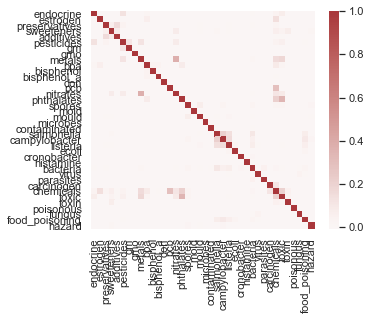

In [15]:
sns.set(rc={'figure.figsize':(5,4)})
sns.heatmap(countdf[make_underscores(h)].corr().dropna(axis=0, how='all').dropna(axis=1,how='all'), \
            cmap= "vlag", center=0.00, xticklabels=True, yticklabels=True)

### Check Correlations from Counts

Text(0.5, 1.0, 'Products & Hazards')

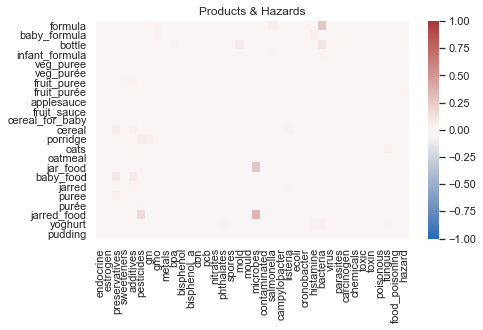

In [16]:
sns.set(rc={'figure.figsize':(7,4)})
sns.heatmap(countdf.corr().loc[make_underscores(p), make_underscores(h)].dropna(axis=0, how='all').dropna(axis=1,how='all'), \
           cmap= "vlag", vmax=1.0, vmin=-1.0, center=0.00, xticklabels=True, yticklabels=True)
plt.title('Products & Hazards')

Text(0.5, 1.0, 'Hazards & Max Filtered Counts')

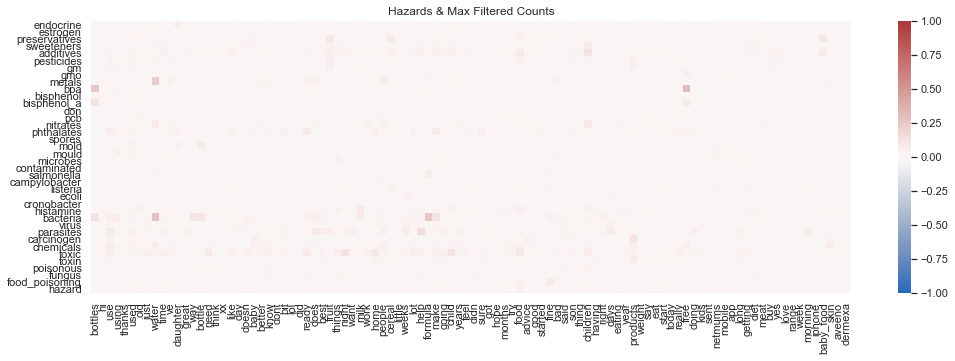

In [17]:
sns.set(rc={'figure.figsize':(17,6)})
temp_concat_df = pd.concat([countdf, maxcountdf], axis=1)
temp_concat_df = temp_concat_df.loc[:,~temp_concat_df.columns.duplicated()]

sns.set(rc={'figure.figsize':(17,5)})
sns.heatmap(temp_concat_df.corr().loc[make_underscores(h), maxcountdf.columns].dropna(axis=0, how='all').dropna(axis=1,how='all'), \
            cmap= "vlag", vmax=1.0, vmin=-1.0, center=0.00, xticklabels=True, yticklabels=True)
plt.title('Hazards & Max Filtered Counts')
#FIXME: column names in teh df are getting doubles, due to the pd.concat having it twice. I need to first figure out why the counts arent exactly the same in boht oclumns tho.

Text(0.5, 1.0, 'Hazards & TF-IDF Filtered Counts')

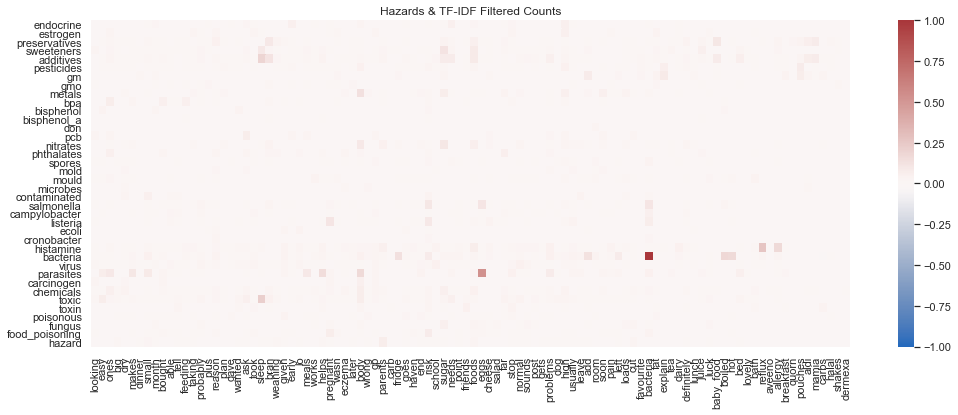

In [18]:
temp_concat_df = pd.concat([countdf, maxdfcountdf], axis=1)
temp_concat_df = temp_concat_df.loc[:,~temp_concat_df.columns.duplicated()]

sns.set(rc={'figure.figsize':(17,6)})
sns.heatmap(temp_concat_df.corr().loc[make_underscores(h), maxdfcountdf.columns].dropna(axis=0, how='all').dropna(axis=1,how='all'), \
            cmap= "vlag", vmax=1.0, vmin=-1.0, center=0.00, xticklabels=True, yticklabels=True)
plt.title('Hazards & TF-IDF Filtered Counts')

## Join Data into Single DataFrame

In [19]:
summed_df = pd.DataFrame()

for key in products.keys():
    summed_df[key] = countdf[make_underscores(products[key])].sum(axis=1)
for key in hazards.keys():
    summed_df[key] = countdf[make_underscores(hazards[key])].sum(axis=1)
for key in extras.keys():
    summed_df[key] = countdf[make_underscores(extras[key])].sum(axis=1)

### process the fruit, vegetable, baby columns

Idea: we only want to count mentions of fruit in the context of baby food. So we take the count of fruit and multiply it by the whether the mentions of baby are non-zero or not.

In [20]:
#count mentions of fruit or vegetable
#return 0 if there is no words indicating a context of BABY foods (not adult foods)
#note that baby food brand names occur much more than fruit or veg. Am not sure if they co-occur.
#TODO: maybe it is better to add the brands in with the fruit / veg. But since it is highly corr with them alreayd, at least looking by post it isnt a problem
summed_df['fruit_in_baby_context'] = summed_df['fruit']  * (summed_df[['baby_food_brands', 'food_or_formula_brands', 'baby']].sum(axis=1) > 0)
summed_df['veg_in_baby_context'] = summed_df['vegetable']  * (summed_df[['baby_food_brands', 'food_or_formula_brands', 'baby']].sum(axis=1) > 0)

#if there is mention of fruit or vegetable it's not uncategorized. return 0
# if no mentions, sum the counts of mentions of baby food brands
# possible improvement: check for words indicating a food, or in weaning forum etc. THEN we can also add food_or_formula_brands to the COUNT.
summed_df['baby_food_uncategorized'] = (summed_df[['fruit','vegetable']].sum(axis=1) > 0) * summed_df['baby_food_brands']

In [21]:
class_df = summed_df.copy()

In [22]:
product_cols = list(products.keys()) + ['veg_in_baby_context', 'fruit_in_baby_context', 'baby_food_uncategorized']

# Classify

## Count Approach

In [23]:
#classify
class_df['product_type'] = class_df[product_cols].idxmax(axis=1)
# idxmax has a strange behavior where it will set all-zero sets to an arbitrary category (the first one available?)
# so we must manually change them to an NA category.
class_df.loc[class_df[product_cols].max(axis=1) == 0,'product_type'] = 'NA'
# convert to categorical (factors)
class_df['product_type'] = class_df['product_type'].astype('category')

In [24]:
#make classification for hazards and check it as well.
class_df['hazard_type'] = class_df[hazards.keys()].idxmax(axis=1)
class_df.loc[class_df[hazards.keys()].max(axis=1) == 0,'hazard_type'] = 'NA'
class_df['hazard_type'] = class_df['hazard_type'].astype('category')

### Check the Resulting Totals

#### Total Count

In [25]:
#note: we have classified hazards but for this section it is not useful to look at, 
#we look further into it in later sections focusing on sentiment analysis.
class_df['hazard_type'].value_counts()

NA                                              18491
other bacteria                                    347
related terms                                     296
food preservatives, sweeteners and additives      113
microbiologic contaminants                        100
virus                                              79
bisphenol a                                        67
listeria                                           60
salmonella                                         36
pesticides                                         21
histamine                                          16
parasites                                          11
gmo                                                 8
campylobacter                                       8
endocrine disruptor                                 7
metals                                              3
ecoli                                               3
nitrates                                            2
phthalates                  

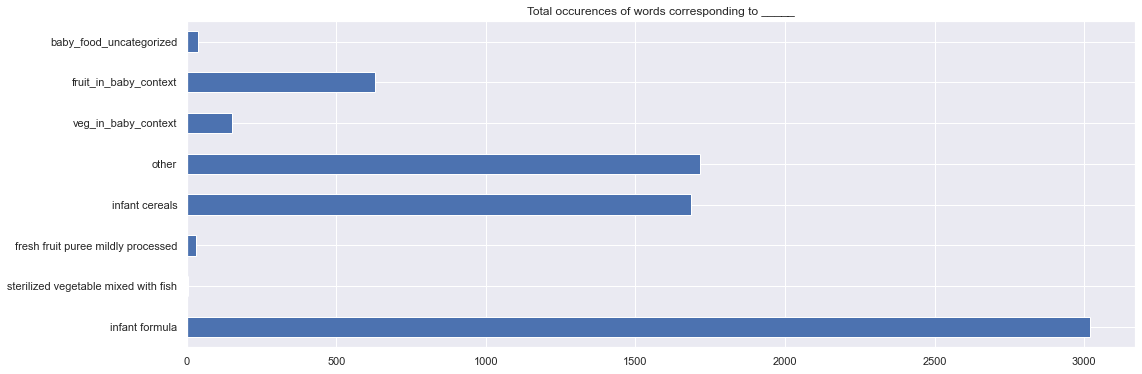

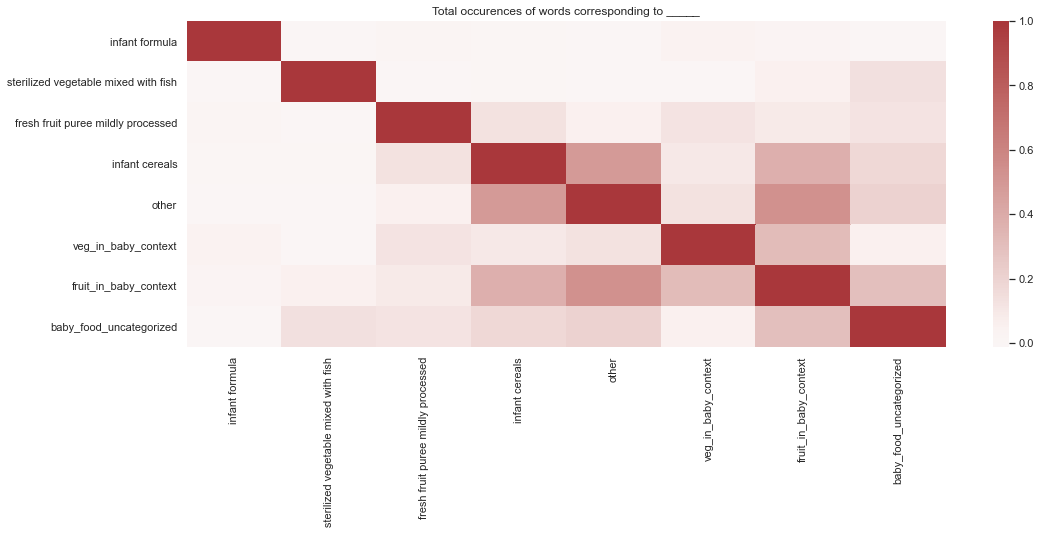

In [26]:
class_df[product_cols].sum(axis=0).plot(kind='barh')
plt.title('Total occurences of words corresponding to _____')
plt.show()
sns.heatmap(class_df[product_cols].corr(), cmap= "vlag", center=0.00)
plt.title('Total occurences of words corresponding to _____')
plt.show()

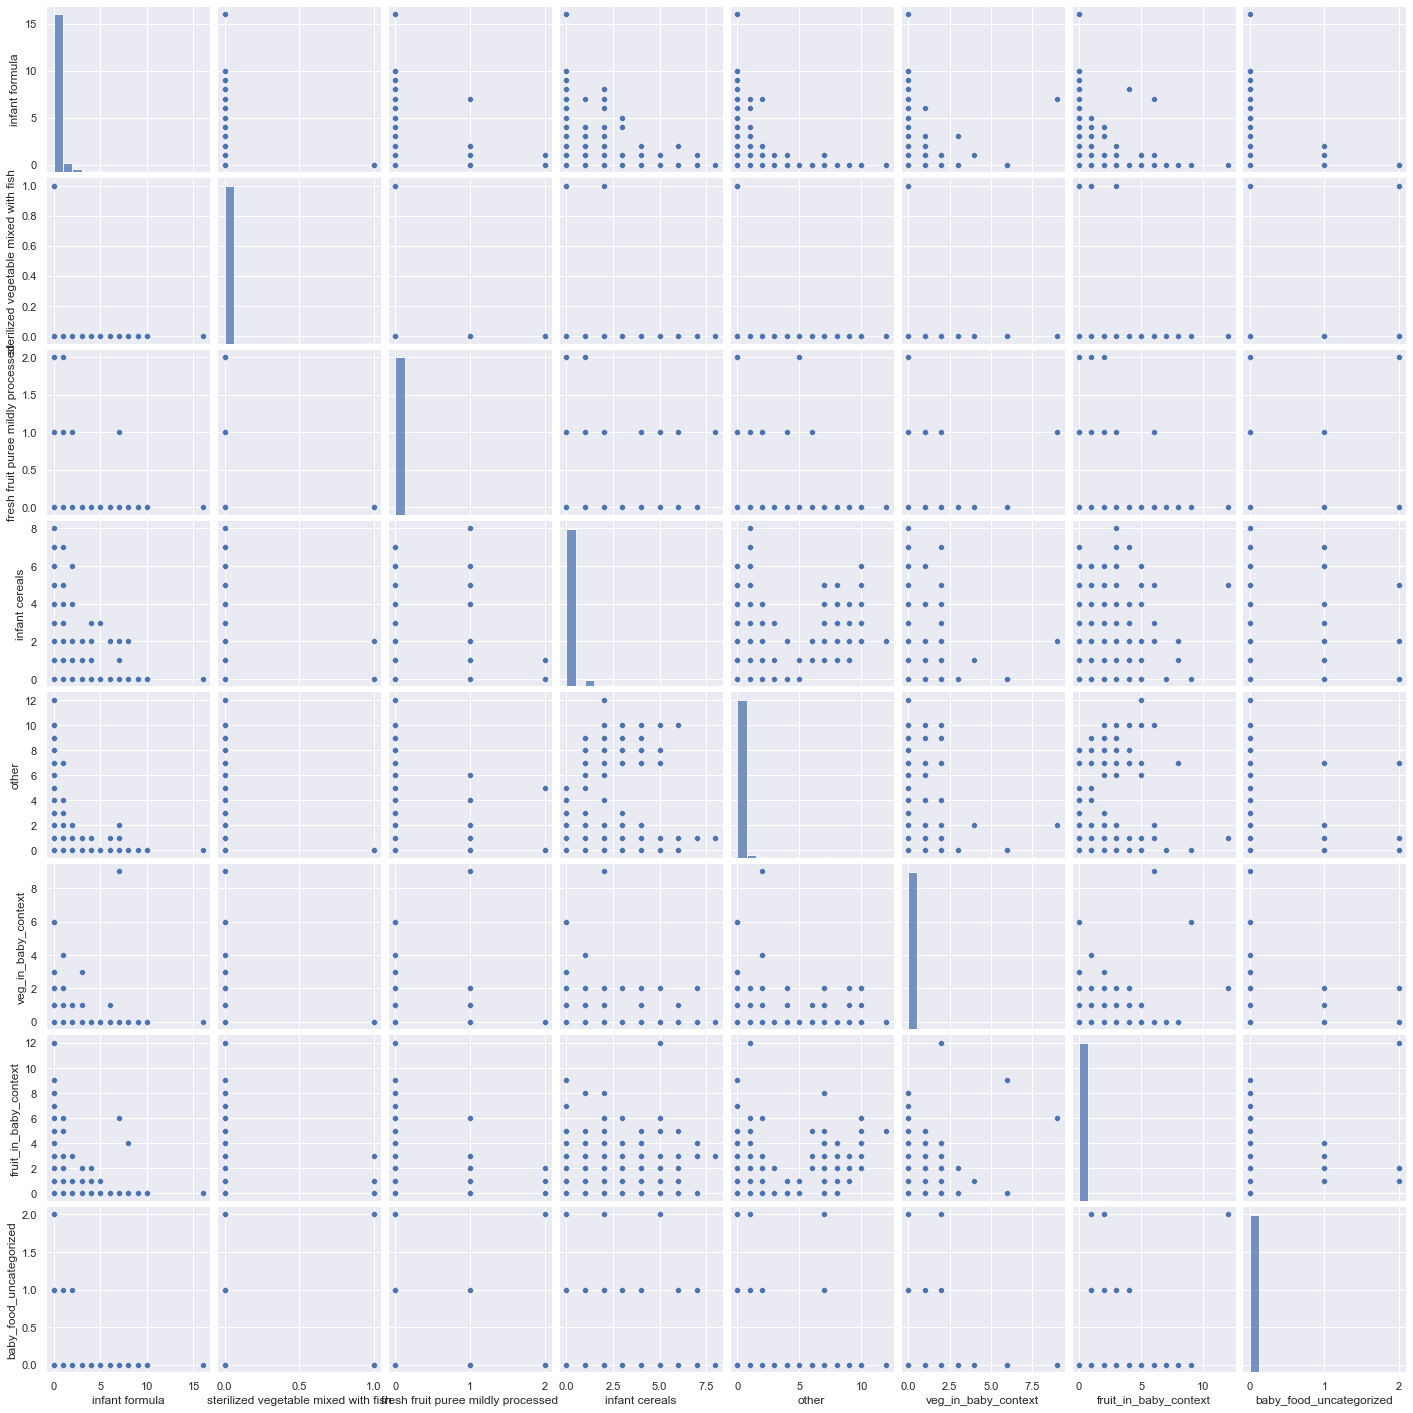

In [27]:
sns.pairplot(class_df[product_cols])

#### Number of Posts Containing an Occurence

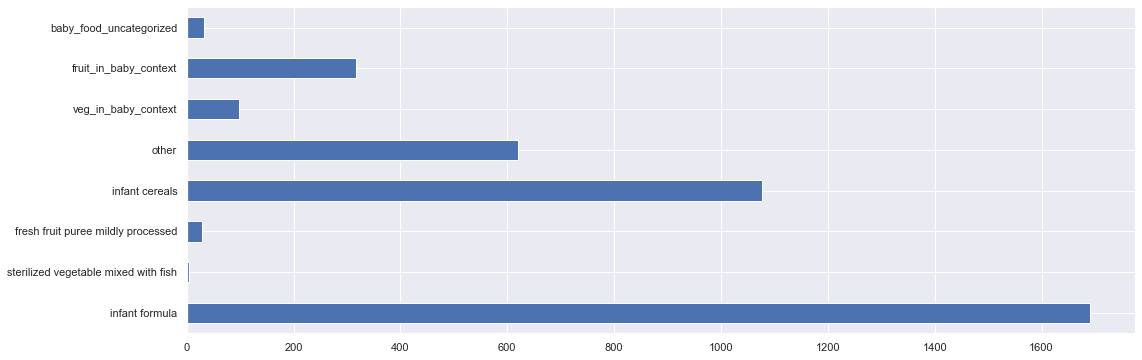

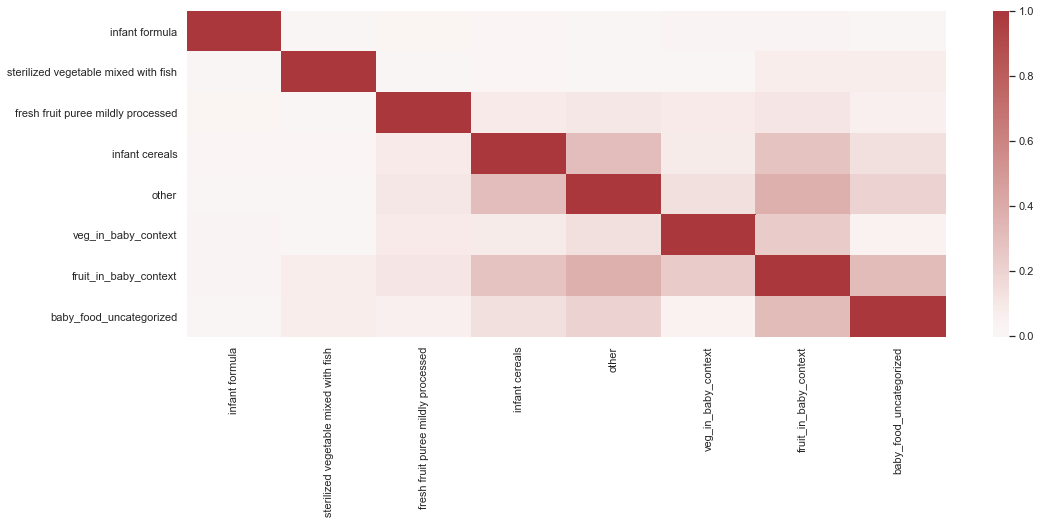

In [28]:
(class_df[product_cols] > 0).sum(axis=0).plot(kind='barh')
plt.show()
sns.heatmap((class_df[product_cols] > 0).corr(), cmap= "vlag", center=0.00)
plt.show()

# Check the Classification

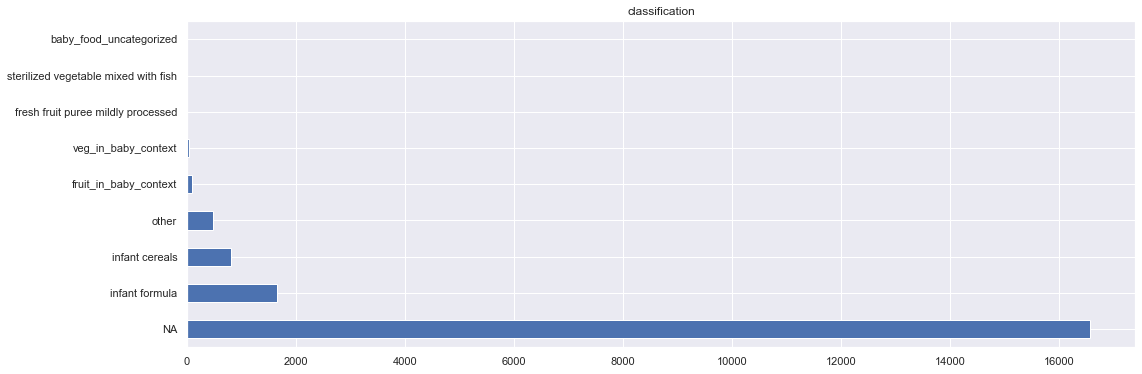

<AxesSubplot:title={'center':'classification (log scale)'}>

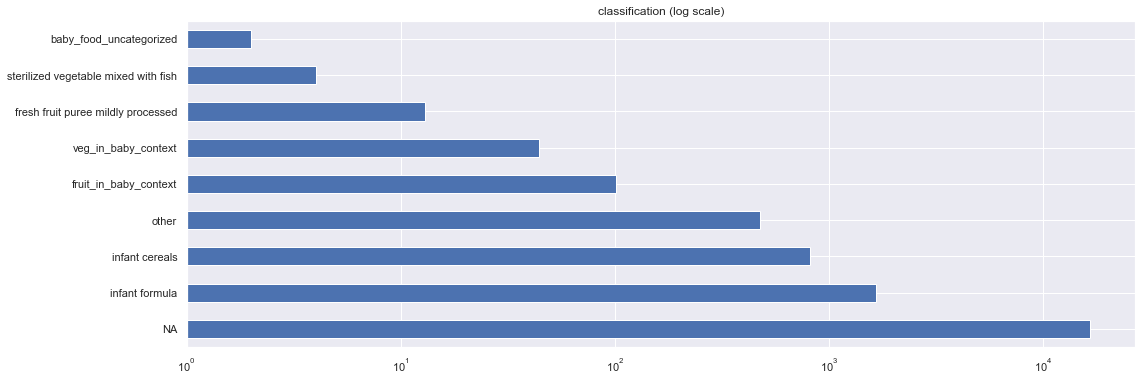

In [29]:
sns.set(rc={'figure.figsize':(5,4)})
class_df['product_type'].value_counts().plot.barh(title = 'classification')
plt.show()

class_df['product_type'].value_counts().plot.barh(title='classification'+ ' (log scale)', log=True)

## Hazard Occurences by Product Class

### Number of Occurences

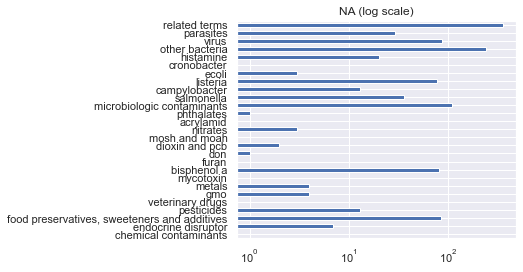

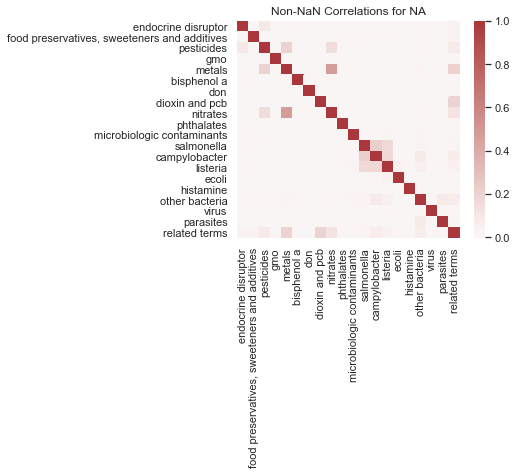

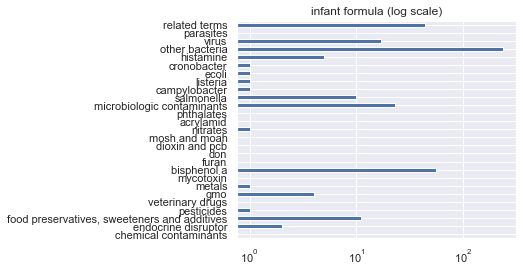

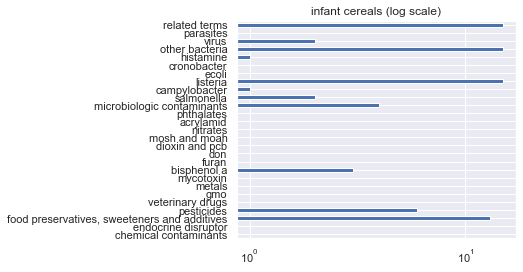

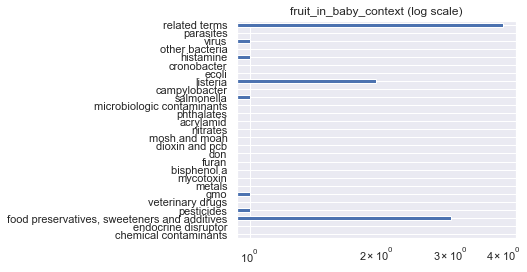

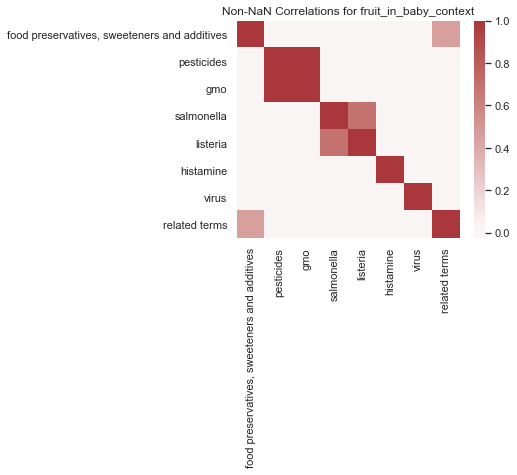

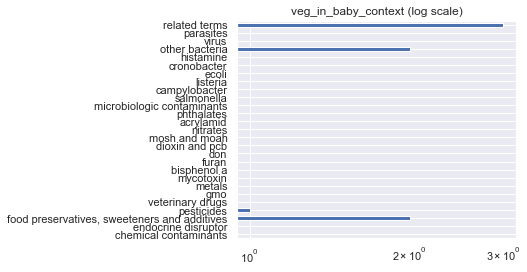

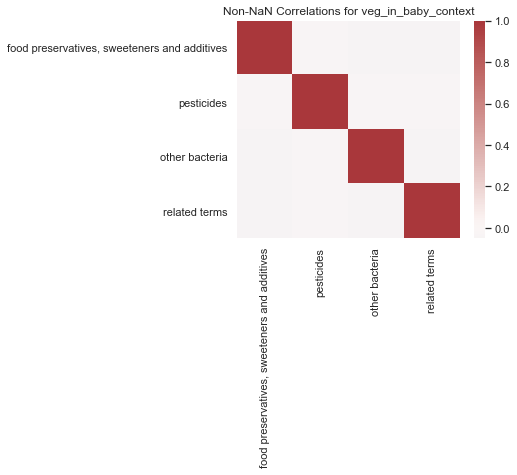

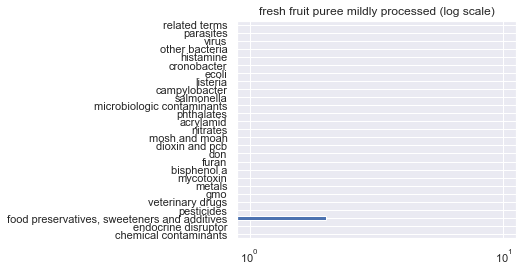

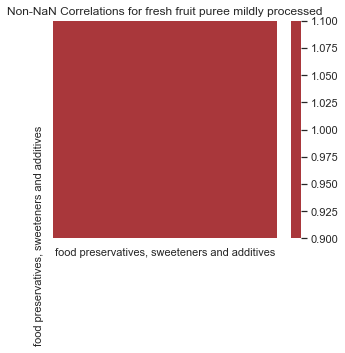

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:532: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()


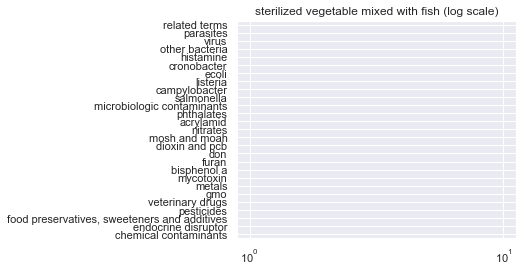

[insufficient data to render sterilized vegetable mixed with fish plot! ]


/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:532: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()


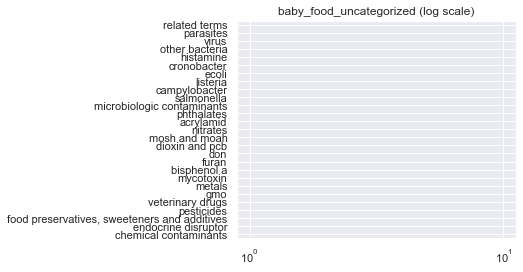

[insufficient data to render baby_food_uncategorized plot! ]


In [138]:
sns.set(rc={'figure.figsize':(5,4)})
for category in list(class_df['product_type'].value_counts().index): #get the non-zero labels (zero labels may create an error)
    try:
        class_df.loc[class_df.product_type == category][hazards.keys()].sum(axis=0).plot.barh(title=category+ ' (log scale)', log=True)
        plt.show()
    except ValueError:
        print('[insufficient data to render %s plot! ]' % (category))
        
    non_nan_correlation = class_df.loc[class_df.product_type == category][hazards.keys()].corr().dropna(axis=1, how='all').dropna(axis=0, how='all')
    try:
        sns.heatmap(non_nan_correlation, cmap= "vlag", center=0.00, xticklabels=True, yticklabels=True)
        plt.title('Non-NaN Correlations for ' + str(category))
        plt.show()
    except ValueError:
        print('[insufficient data to render %s plot! ]' % (category))

### Number of Posts Containing an Occurence

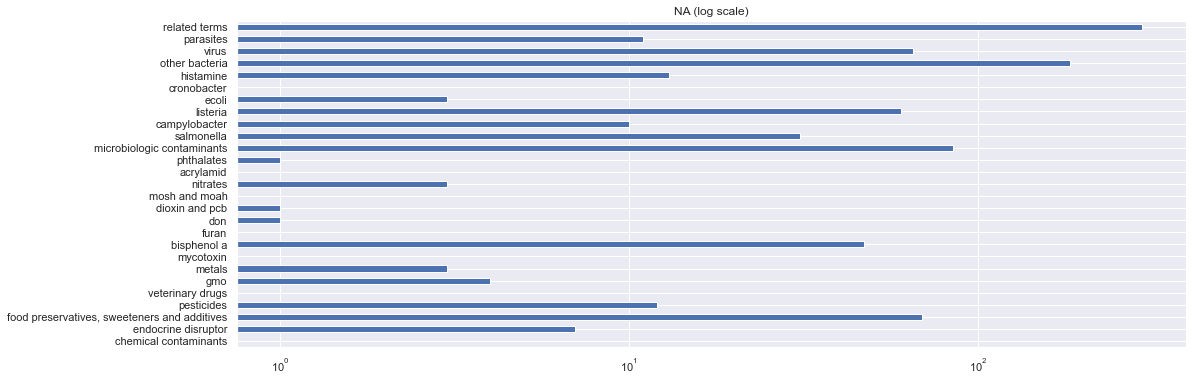

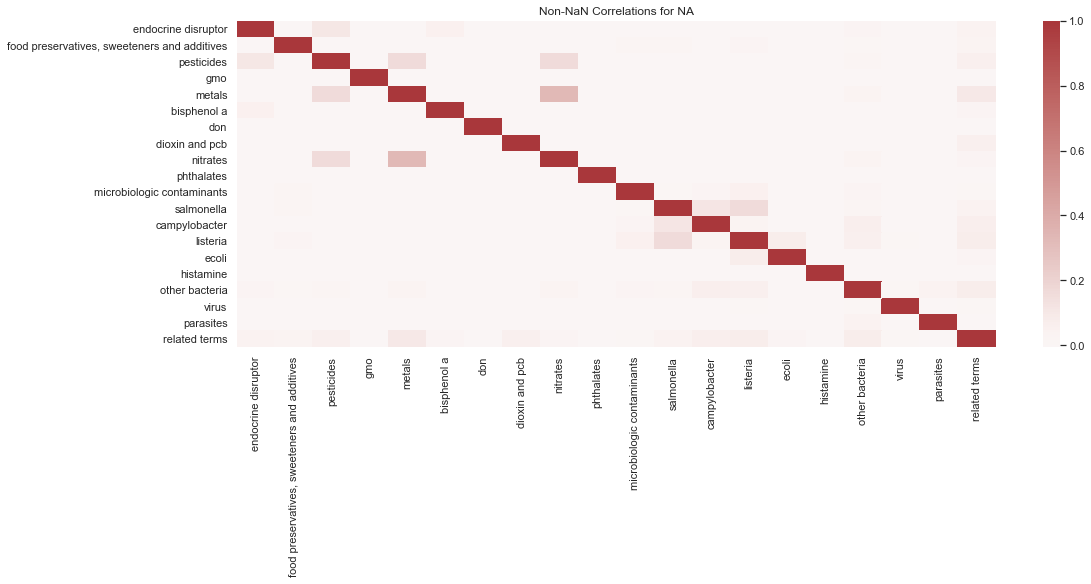

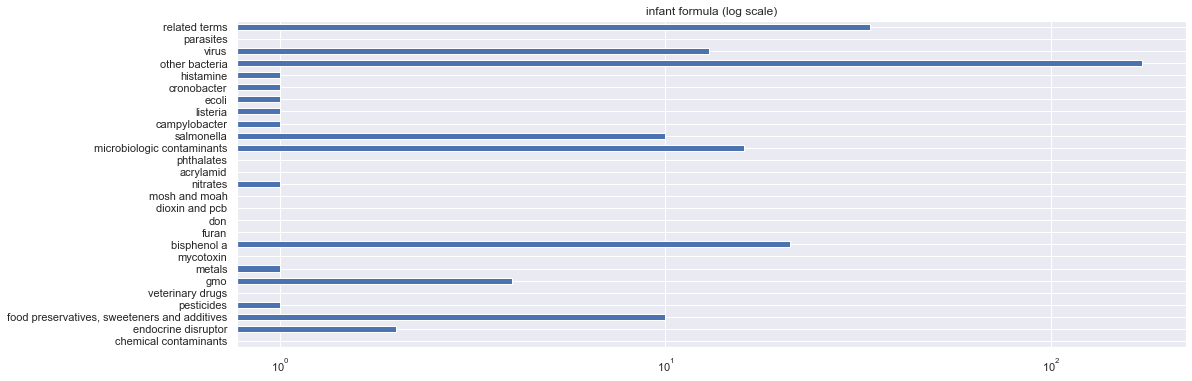

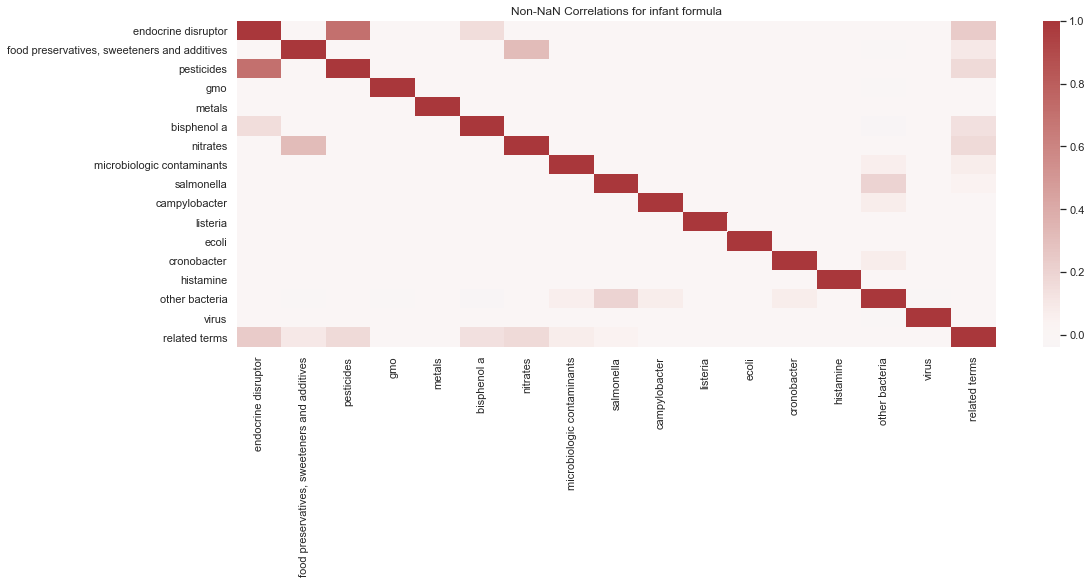

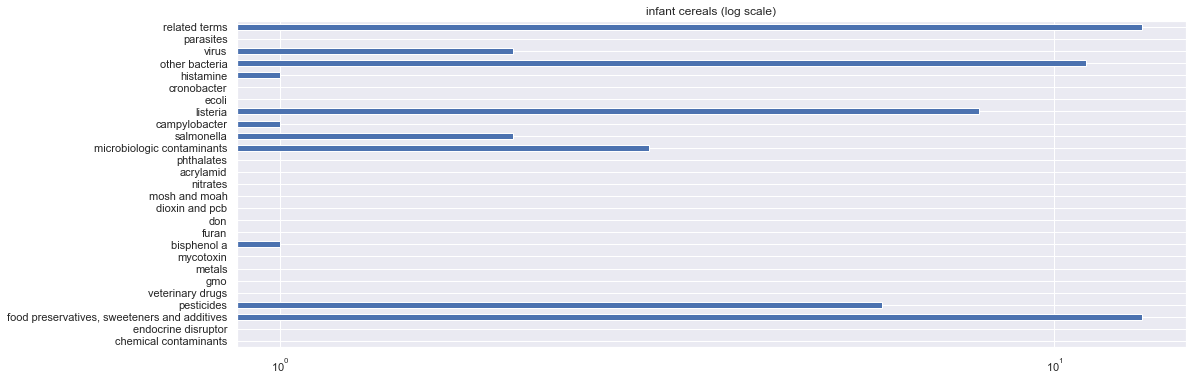

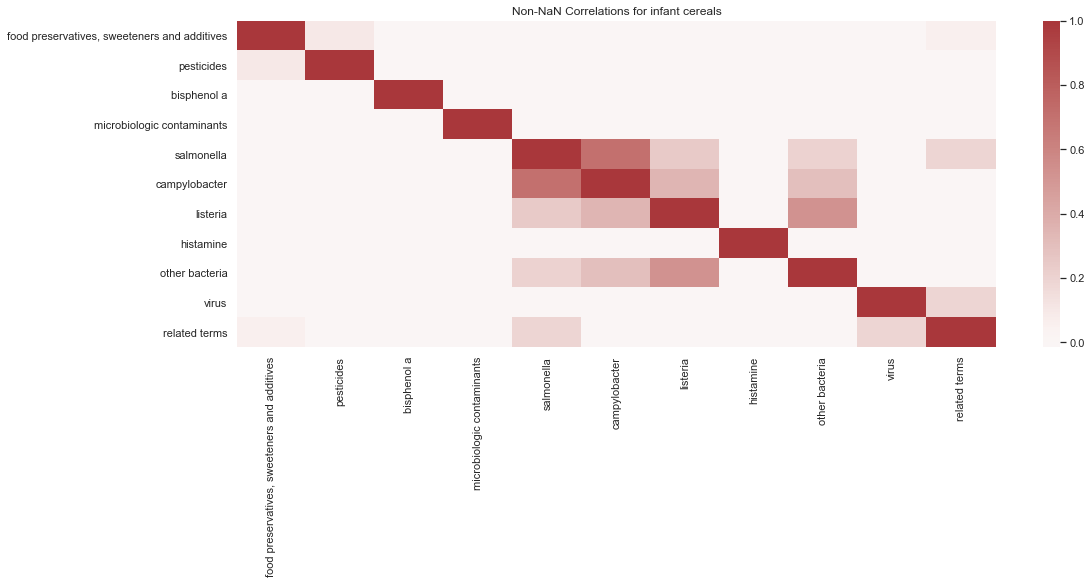

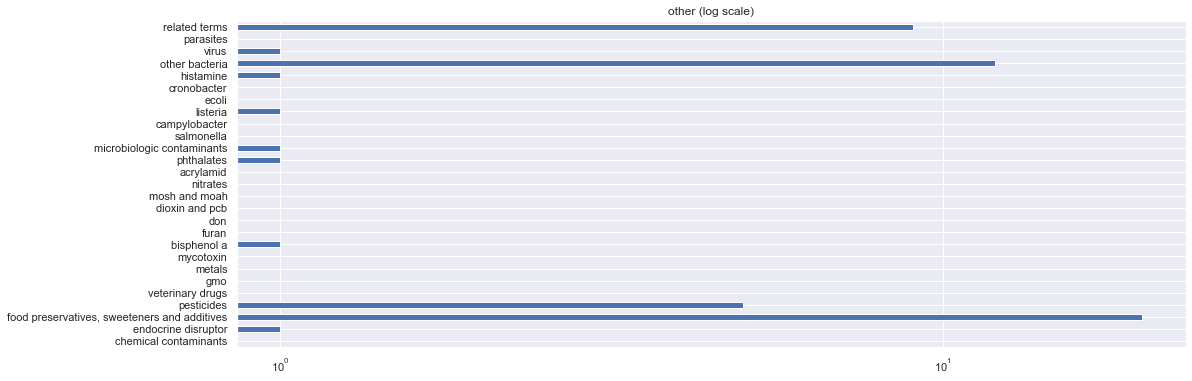

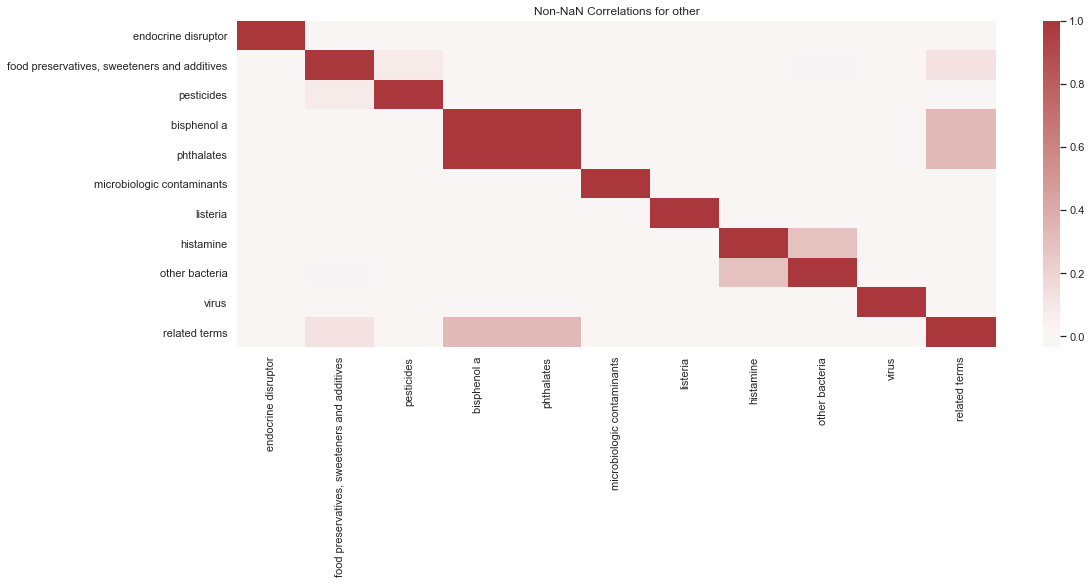

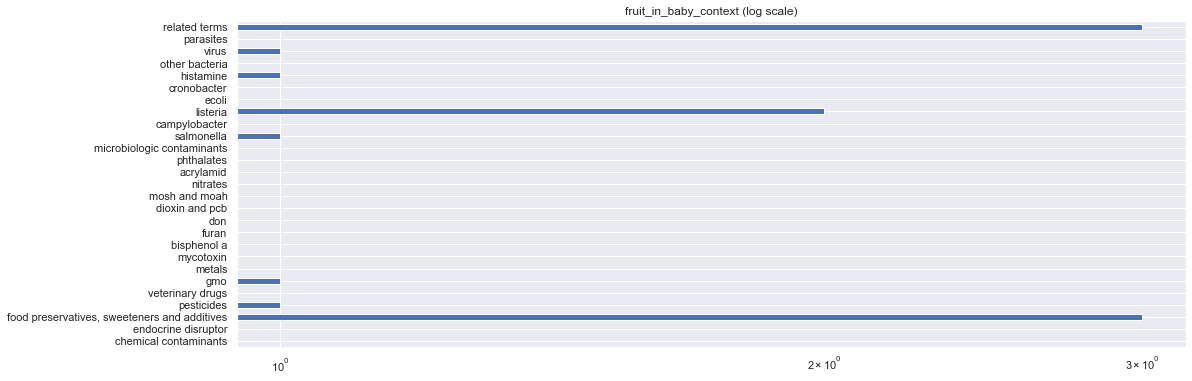

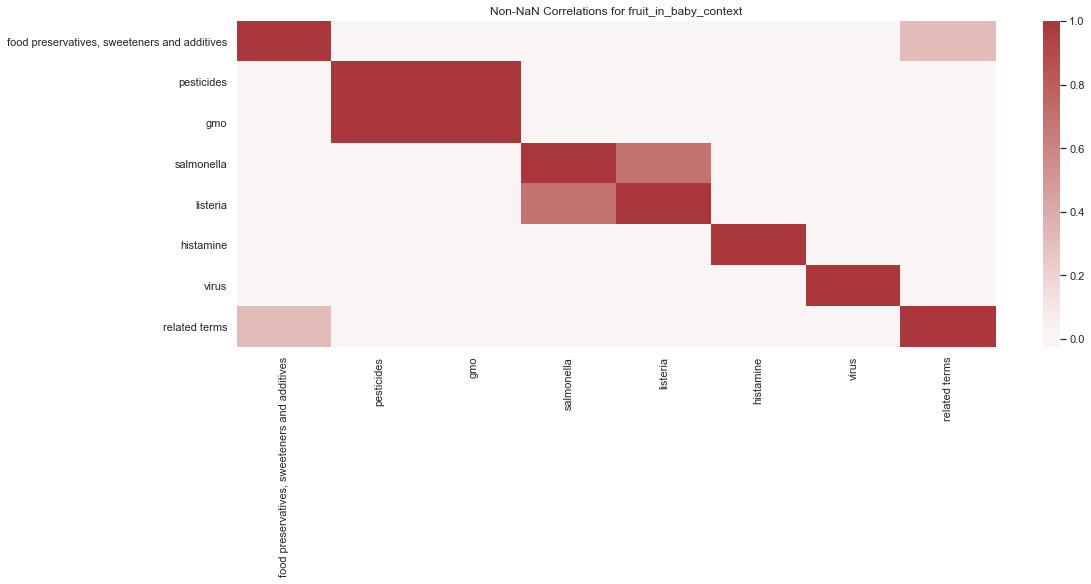

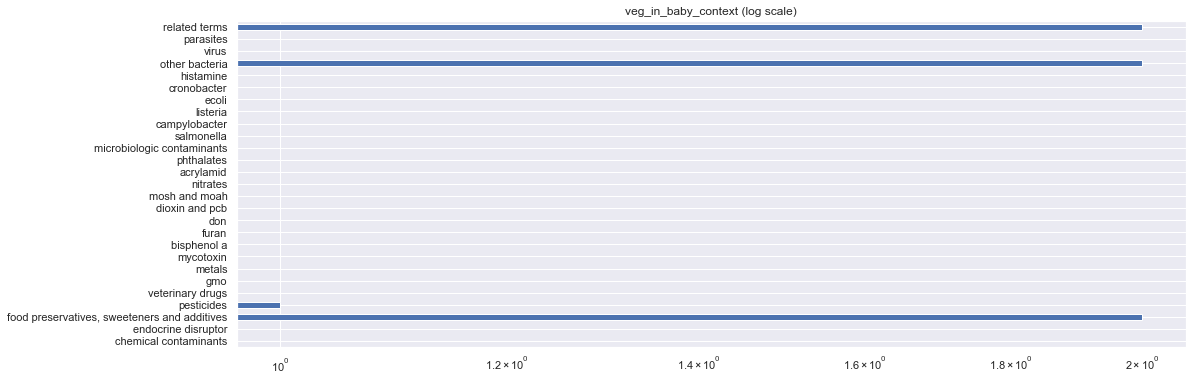

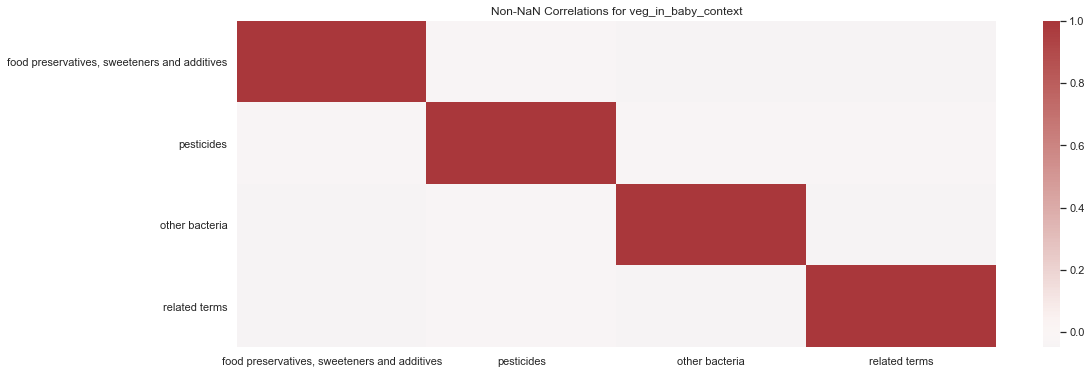

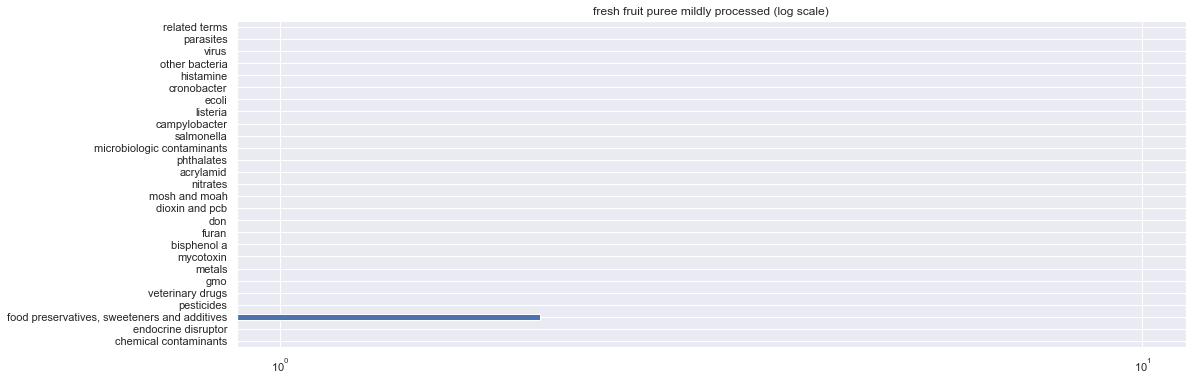

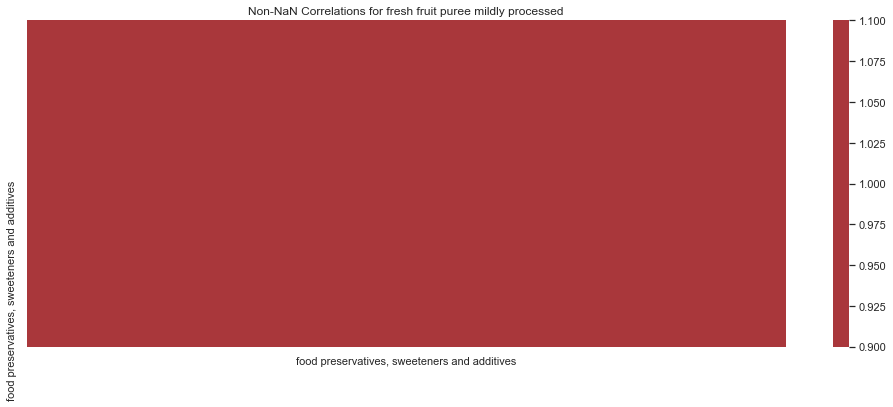

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:532: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()


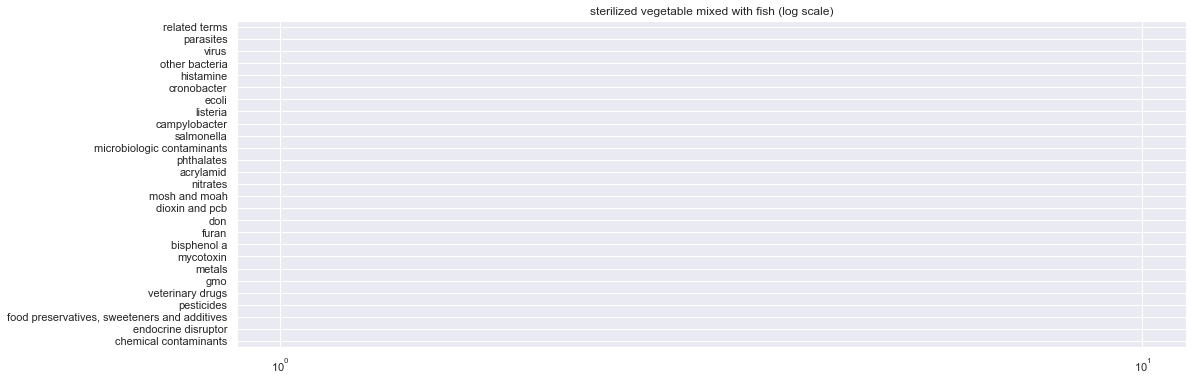

[insufficient data to render sterilized vegetable mixed with fish plot! ]


/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:532: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()


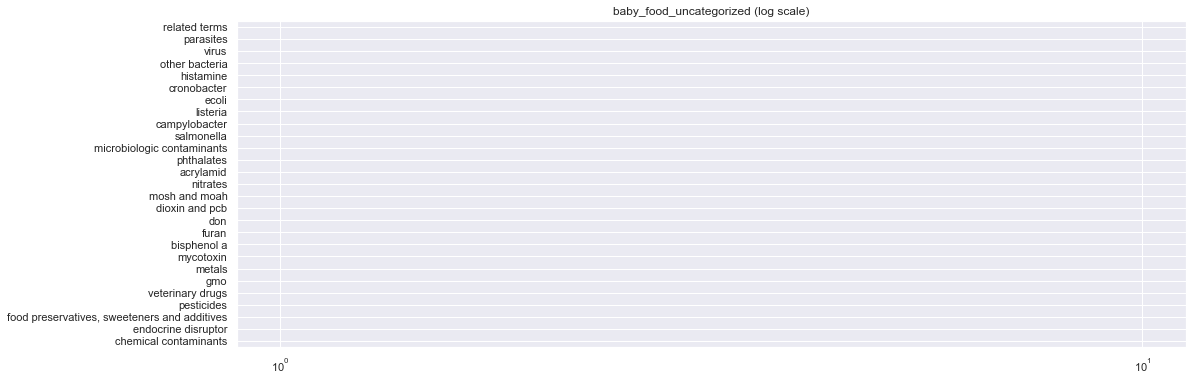

[insufficient data to render baby_food_uncategorized plot! ]


In [31]:
sns.set(rc={'figure.figsize':(5,4)})
for category in list(class_df['product_type'].value_counts().index): #get the non-zero labels (zero labels may create an error)
    num_of_posts = class_df.loc[class_df.product_type == category][hazards.keys()] > 0
    
    try:
        num_of_posts.sum(axis=0).plot.barh(title=category+ ' (log scale)', log=True)
        plt.show()
    except ValueError:
        print('[insufficient data to render %s plot! ]' % (category))
        
    non_nan_correlation = num_of_posts.corr().dropna(axis=1, how='all').dropna(axis=0, how='all')
    try:
        sns.heatmap(non_nan_correlation, cmap="vlag", center=0.00,xticklabels=True, yticklabels=True)

        plt.title('Non-NaN Correlations for ' + str(category))
        plt.show()
    except ValueError:
        print('[insufficient data to render %s plot! ]' % (category))

# Running KNN on the processed numbers. (maybe) TODO 

# Guided LDA Approach... TODO

 how many possible cateorgires do we have?
 4 Products
 18 Hazards

 so we do
     * k = 4
     * k = 18
     * k = $18*4$ = 72


In [ ]:
# This has been done already in another notebook! :)
# I also want to do non-guided LDA and we can use those topics in a regression?.

#  Feature Extraction: Sentiment Analysis

## NLTK Vader Sentiment Analysis
https://www.nltk.org/howto/sentiment.html


* calculate sentiment for each post
* save it into dataframe.

The VADER algorithm outputs sentiment scores to 4 classes of sentiments https://github.com/nltk/nltk/blob/develop/nltk/sentiment/vader.py#L441:

* neg, neu, pos - ratios for proportions of text that fall in each category (negative, neutral, positive)
    * neg + neu + pos = 1
    * in [0,1]
    * IMPORTANTLY: these proportions represent the "raw categorization" of each lexical item (e.g., words, emoticons/emojis, or initialisms) into positve, negative, or neutral classes; they do not account for the VADER rule-based enhancements such as word-order sensitivity for sentiment-laden multi-word phrases, degree modifiers, word-shape amplifiers, punctuation amplifiers, negation polarity switches, or contrastive conjunction sensitivity.
* compound - composite score, with added VADER weightings and rules, and normalized
    * in [-1,1]

more details: https://github.com/cjhutto/vaderSentiment#about-the-scoring

In [32]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

In [33]:
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /Users/sma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sma/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [34]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#initialize object
sid = SentimentIntensityAnalyzer()

In [35]:
def nltk_sentiments(text):
    """
    Split sentences, parse and get modality of sentences, then return the mean of the modalities. (or something, #TODO)
    We need to split sentences because sentence structure is parsed. In sentiment anal it uses bag of words instead #TODO: verify this. I know nltk uses bag of words
    """
    sentences = tokenize.sent_tokenize(text)
    #remove sentences which have no alphabet data, they will bias our results.
    #this could also remove emoticons but oh well.
    #TODO: add THE SAME cleaning into the patterns one.
    #TODO: add code to remove sentences which only contain the letter X (there is a LOT of these on netmums tbh.)
    sentences = [sentence for sentence in sentences if sentence.upper().isupper()]
    sentiments = [sid.polarity_scores(sentence) for sentence in sentences]
    try:
        sentiment_keys = list(sentiments[0].keys())
        means = {sentiment_keys[ind]: np.mean(nums) for ind,nums in enumerate(list(zip(*[list(i.values()) for i in sentiments])))}
        variances = {sentiment_keys[ind]: np.var(nums) for ind,nums in enumerate(list(zip(*[list(i.values()) for i in sentiments])))}
        return means, variances
    except IndexError:
        sad_dict = {'neg':None, 'neu': None, 'pos':None, 'compound':None}
        return sad_dict, sad_dict
        

In [36]:
#run it
start = time.time()
temp = [(key, nltk_sentiments(posts_dict[key]['body'])) for key in class_df.index]

keys, sentiments_by_sentence = zip(*temp)
end = time.time()


#the tuple contains [0]:mean, [1]:var, we assign 
#the means of each feature and the vars of each feature
#to a new columns in the dataframe.

class_df['nltk_neg_mean'], class_df['nltk_neg_var'] =  \
        pd.Series([i[0].get('neg') for i in sentiments_by_sentence], index=keys), \
            pd.Series([i[1].get('neg') for i in sentiments_by_sentence], index=keys)

class_df['nltk_neu_mean'], class_df['nltk_neu_var'] =  \
        pd.Series([i[0].get('neu') for i in sentiments_by_sentence], index=keys), \
            pd.Series([i[1].get('neu') for i in sentiments_by_sentence], index=keys)

class_df['nltk_pos_mean'], class_df['nltk_pos_var'] =  \
        pd.Series([i[0].get('pos') for i in sentiments_by_sentence], index=keys), \
            pd.Series([i[1].get('pos') for i in sentiments_by_sentence], index=keys)

class_df['nltk_compound_mean'], class_df['nltk_compound_var'] =  \
        pd.Series([i[0].get('compound') for i in sentiments_by_sentence], index=keys), \
            pd.Series([i[1].get('compound') for i in sentiments_by_sentence], index=keys)

print(end-start)

37.97146701812744


## Patterns Measures
https://github.com/clips/pattern/wiki/pattern-en#sentiment
https://github.com/clips/pattern/wiki/pattern-en#mood--modality

* Sentiment - from -1 to 1
* Objectivity/Subjectivity - from 0 to 1
* Modality - from -1 to 1

mood simply has a grammar detection system and returns the first mood signalled by grammar that is detected in a sentence.

modality - "Epistemic modality" is used to express possibility (i.e. how truthful is what is being said).

 The modality() function was tested with BioScope and Wikipedia training data from CoNLL2010 Shared Task 1.
 See for example Morante, R., Van Asch, V., Daelemans, W. (2010):
 Memory-Based Resolution of In-Sentence Scopes of Hedge Cues
 http://www.aclweb.org/anthology/W/W10/W10-3006.pdf
 Sentences in the training corpus are labelled as "certain" or "uncertain".
 For Wikipedia sentences, 2000 "certain" and 2000 "uncertain":
 modality(sentence) > 0.5 => A 0.70 P 0.73 R 0.64 F1 0.68

In [37]:
from pattern.en import sentiment

In [38]:
#debug
sentiment([i for i in posts_dict.values()][0]['body'])

(0.1266666666666667, 0.6666666666666667)

In [39]:
#illustrate how we can check individual word values with pattern.
sentiment([i for i in posts_dict.values()][0]['body']).assessments

[(['easy'], 0.43333333333333335, 0.8333333333333334, None),
 (['huge'], 0.4000000000000001, 0.9, None),
 (["n't", 'fit'], -0.2, 0.4, None),
 ([':/'], -0.25, 1.0, 'mood'),
 (['thanks', '!'], 0.25, 0.2, None)]

In [40]:
#calculate sentiments using pattern
keys, sent_and_subj = zip(*[(key, sentiment(posts_dict[key]['body'])) for key in class_df.index])
subj, sent = zip(*sent_and_subj)
del sent_and_subj
#save it to dataframe.
class_df['sentiment'], class_df['subjectivity'] =  pd.Series(sent, index=keys), pd.Series(subj, index=keys)

In [41]:
from pattern.en import parse, Sentence
from pattern.en import modality, mood

In [42]:
#The current version (3.6) of pattern has been unmaintained and the fix for this has not been implemented.
#This is a hacky method of getting around the error
#I suggest that you modify the pattern package yourself as described here (https://github.com/clips/pattern/issues/308)

#This hacky fix is included in order to maintain compatibility for those who have just installed the package.
#
# If you ever get RuntimeError, just try to rerun that cell until it doesnt give an error and then the rest from there.

i = 0
j = 0
while i == 0: #WORKAROUND
    j += 1
    try:
        modality(Sentence(parse('''Please stop giving me StopIteration Error!''')))
        if j > 4:
            i += 1
        print('pattern.en said ok.')
    except RuntimeError:
        print('pattern.en said no.')
        pass

pattern.en said no.
pattern.en said no.
pattern.en said ok.
pattern.en said ok.
pattern.en said ok.


In [43]:
def split_sentences(text):
    sentence_separators = re.findall('[\n?!.]+', text) + ['']
    sentences = re.split('[\n?!.]+', text)
    for ind, _ in enumerate(sentence_separators): #we keep the punctuation which sep sentences bc question marks are used in modality calculation.
        sentences[ind] += sentence_separators[ind]
    return sentences

def parse_and_get_m(text, get_mood=False, get_modal=True):
    """
    Split sentences, parse and get modality of sentences, then return the mean of the modalities. (or something, #TODO)
    We need to split sentences because sentence structure is parsed. In sentiment anal it uses bag of words instead #TODO: verify this. I know nltk uses bag of words
    """
    sents= [Sentence(parse(s, lemmata=True)) for s in split_sentences(text)] #I don't think the punctuations are used in modality or mood detection.
    ## Debug note: i forgot to parse and convert to Sentence object, but it ran fine (same results too).
    ## But now on re-running and debugging due to an error mentioned above,
    ## it seems that it is slow, regardless if I parse sentences myself or not.
    if get_mood:
        if get_modal:
            return [(modality(s), mood(s)) for s in sents]
        else:
            return [ mood(s) for s in sents]
    elif get_modal:
        return [modality(s) for s in sents]
    else:
        return None
        

In [44]:
#run it
start = time.time()
try: #ANOTHER WORKAROUND for this package. It needs to be run twice. No idea why.
    temp = [(key, parse_and_get_m(posts_dict[key]['body'])) for key in class_df.index]
except:
    temp = [(key, parse_and_get_m(posts_dict[key]['body'])) for key in class_df.index]
keys, modalities_by_sentence = zip(*temp)
end = time.time()
%notify

#prepare datatypes and add to dataframe
mean, var = zip(*[(np.mean(x), np.var(x)) for x in modalities_by_sentence])
del modalities_by_sentence

class_df['modality_sentence_mean'], class_df['modality_sentence_var'] =  pd.Series(mean, index=keys), pd.Series(var, index=keys)

<IPython.core.display.Javascript object>

## Plots

##### Prep Functions and Stuff

In [45]:
#code to generate colors for denisty of points of scatter plot.

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde as kde
from matplotlib.colors import Normalize
from matplotlib import cm
#source: https://stackoverflow.com/questions/19064772/visualization-of-scatter-plots-with-overlapping-points-in-matplotlib

def makeColours( vals ):
    colours = np.zeros( (len(vals),3) )
    norm = Normalize( vmin=vals.min(), vmax=vals.max() )

    #Can put any colormap you like here.
    colours = [cm.ScalarMappable( norm=norm, cmap='jet').to_rgba( val ) for val in vals]

    return colours

def get_cols_and_array_from_df(df, first_col:str,second_col:str):
    #we need to use a np array for kde, and make sure its the correct shape
    sample = np.array(list((zip(*np.array(df[[first_col,second_col]])))))

    #calculate densities per point
    densObj = kde(np.array(list((zip(*np.array(df[[first_col,second_col]]))))))
    # generate colormap
    colours = makeColours( densObj.evaluate( sample ) )
    return sample, colours

def heat_scatter(df, first_col:str, second_col:str, point_size=2):
    try:
        sample, colours = get_cols_and_array_from_df(df, first_col, second_col)
    except ValueError: # if there are NAs remove them
        sample, colours = get_cols_and_array_from_df(class_df.dropna(axis=0, subset=[first_col, second_col]), \
                                                     first_col, second_col)
    plt.scatter(y=sample[0],x=sample[1], color=colours, s=point_size)
    plt.xlabel(second_col)
    plt.ylabel(first_col)
        

### Misc

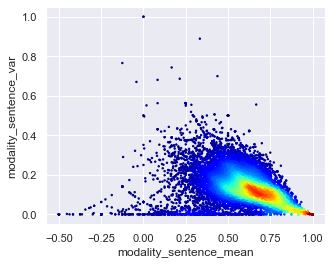

In [46]:
sns.set(rc={'figure.figsize':(5,4)})
heat_scatter(class_df, 'modality_sentence_var','modality_sentence_mean')

### Most Relevant Metrics
pattern_sentiment, pattern_subjectivity, nltk_sentiment

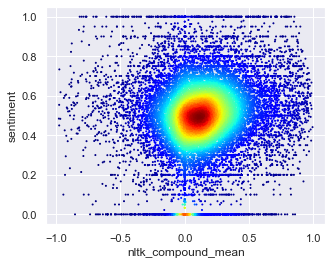

In [47]:
heat_scatter(class_df, 'sentiment','nltk_compound_mean', point_size=1)

<AxesSubplot:xlabel='nltk_compound_mean', ylabel='sentiment'>

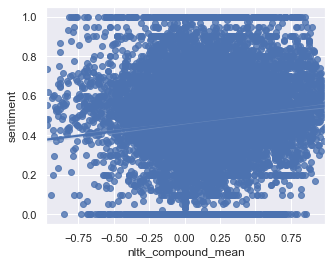

In [48]:
sns.regplot(y= 'sentiment', x ='nltk_compound_mean', data=class_df)

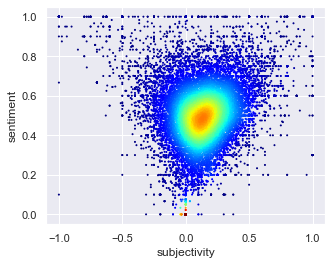

In [49]:
heat_scatter(class_df, 'sentiment','subjectivity', point_size=1)

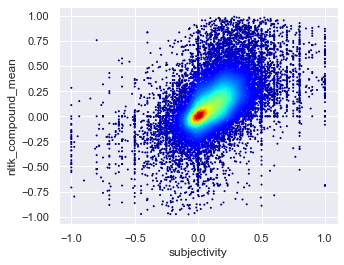

In [50]:
heat_scatter(class_df,'nltk_compound_mean','subjectivity', point_size=1)

### Other stuff

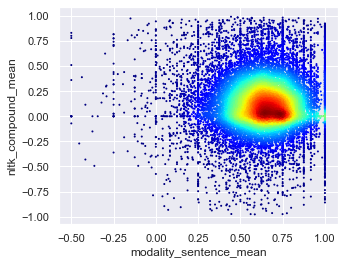

In [51]:
heat_scatter(class_df,'nltk_compound_mean','modality_sentence_mean', point_size=1)

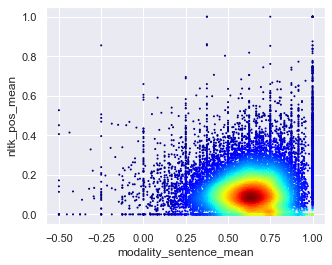

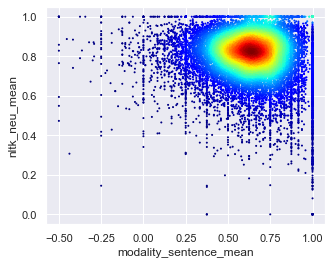

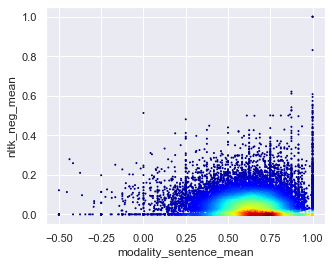

In [52]:
heat_scatter(class_df,'nltk_pos_mean','modality_sentence_mean', point_size=1)
plt.show()
heat_scatter(class_df,'nltk_neu_mean','modality_sentence_mean', point_size=1)
plt.show()
heat_scatter(class_df,'nltk_neg_mean','modality_sentence_mean', point_size=1)
plt.show()

In [53]:
pattern_all = ['sentiment','subjectivity','modality_sentence_mean','modality_sentence_var']
nltk_means = ['nltk_neg_mean','nltk_neu_mean', 'nltk_pos_mean', 'nltk_compound_mean' ]  
nltk_vars = ['nltk_neg_var','nltk_neu_var','nltk_pos_var','nltk_compound_var']

<AxesSubplot:>

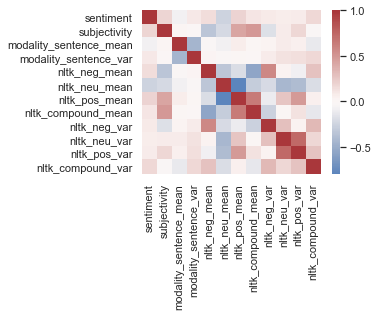

In [54]:
sns.set(rc={'figure.figsize':(4,3)})
sns.heatmap(class_df[pattern_all + nltk_means + nltk_vars].corr(), \
            cmap= "vlag", center=0.00, xticklabels=True, yticklabels=True)

Negative correlations between nltk pos, neu, neg is expected since sum(...) = 1

Correlations with nltk compound reveal the relationship after VADER rules are applied.

Pattern sentiment and ntlk compound are positively correlated which is good, these two scores generally agree.

Subjectivity and Modality are not highly correlated with either, overall. But subjectivity has small (~0.25) negative correlation with neutrality. This is quite intuitive as posts with less strongly indicative words will have more neutral sentiment as well as register a more objective

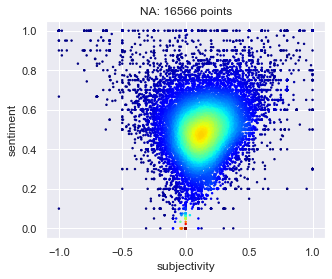

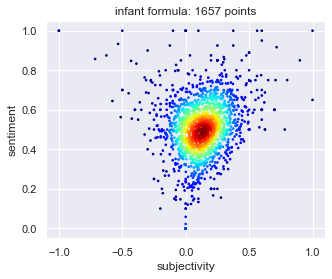

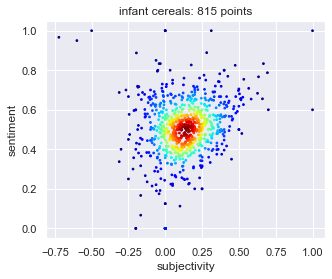

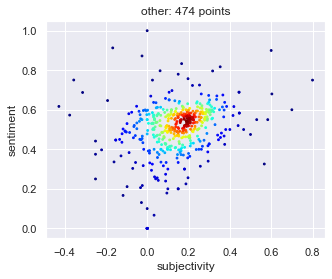

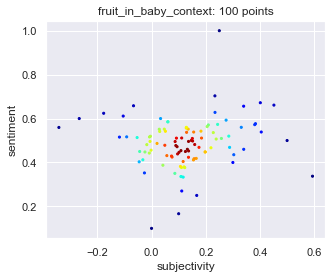

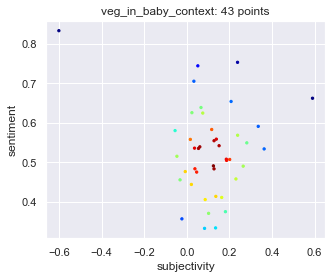

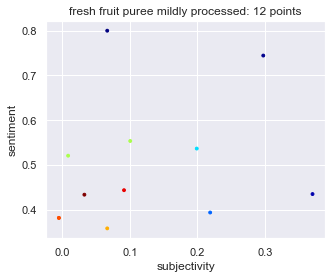

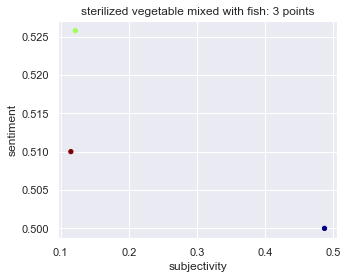

<ipython-input-55-62a519672f6b>:6: RuntimeWarning: divide by zero encountered in double_scalars
  size_for_cat = 20./np.log(len(num_of_posts)) #make points bigger when theres less data to show.
/usr/local/lib/python3.8/site-packages/scipy/stats/kde.py:574: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


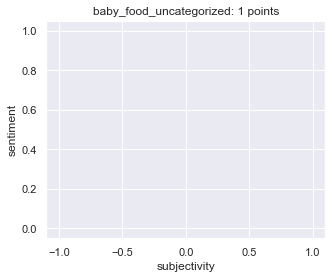

In [55]:
sns.set(rc={'figure.figsize':(5,4)})
errs = []
for category in list(class_df['product_type'].value_counts().index): #get the non-zero labels (zero labels may create an error)
    try:
        num_of_posts = class_df.loc[class_df.product_type == category]
        size_for_cat = 20./np.log(len(num_of_posts)) #make points bigger when theres less data to show.
        heat_scatter(num_of_posts, 'sentiment','subjectivity', point_size=size_for_cat)
        plt.title(category + ': %s points' % len(num_of_posts))
        plt.show()
    except ValueError:
        print(category + ': insufficient data')
    except Exception as exc:
        errs.append(category + ' ' + str(exc))
        errs.append(str(traceback.format_exc()))
print('\n'.join(errs))

In [56]:
class_df.loc[np.abs(class_df['sentiment']) < 0.05].loc[class_df['subjectivity'] < 0.05]

infant formula  \
https://www.netmums.com/coffeehouse/becoming-mu... 16                0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                 1   
https://www.netmums.com/coffeehouse/coffeehouse... 4                 0   
                                                   26                0   
                                                   29                0   
...                                                                ...   
https://www.netmums.com/coffeehouse/becoming-mu... 108               0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                 0   
                                                   6                 0   
                                                   7                 0   
                                                   8                 0   

                                                        sterilized vegetable mixed with fish  \
https://www.netmums.com/coffeehouse/becoming-mu... 16                                      0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                                       0   
https://www.netmums.com/coffeehouse/coffeehouse... 4                                       0   
                                                   26                                      0   
                                                   29                                      0   
...                                                                                      ...   
https://www.netmums.com/coffeehouse/becoming-mu... 108                                     0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                                       0   
                                                   6                                       0   
                                                   7                                       0   
                                                   8                                       0   

                                                        fresh fruit puree mildly processed  \
https://www.netmums.com/coffeehouse/becoming-mu... 16                                    0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                                     0   
https://www.netmums.com/coffeehouse/coffeehouse... 4                                     0   
                                                   26                                    0   
                                                   29                                    0   
...                                                                                    ...   
https://www.netmums.com/coffeehouse/becoming-mu... 108                                   0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                                     0   
                                                   6                                     0   
                                                   7                                     0   
                                                   8                                     0   

                                                        infant cereals  other  \
https://www.netmums.com/coffeehouse/becoming-mu... 16                0      0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                 1      0   
https://www.netmums.com/coffeehouse/coffeehouse... 4                 0      0   
                                                   26                0      0   
                                                   29                0      0   
...                                                                ...    ...   
https://www.netmums.com/coffeehouse/becoming-mu... 108               0      0   
https://www.netmums.com/coffeehouse/becoming-mu... 3                 0      0   
                                                   6                 0      0   
                                                   7                 0     

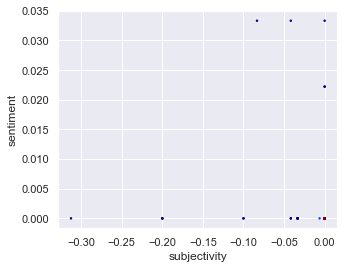

In [57]:
#display the outlier set, zoomed in!
heat_scatter(class_df.loc[np.abs(class_df['sentiment']) < 0.05].loc[class_df['subjectivity'] < 0.05], 'sentiment', 'subjectivity')

In [58]:
num_lower_sentiment = len(class_df.loc[class_df['sentiment'] < 0.1])
num_higher_sentiment = len(class_df.loc[class_df['sentiment'] >= 0.1])
print((num_lower_sentiment, num_higher_sentiment))

num_lower_subj = len(class_df.loc[class_df['subjectivity'] < 0.05])
num_higher_subj = len(class_df.loc[class_df['subjectivity'] >= 0.05])
print((num_lower_subj, num_higher_subj))

(1792, 17879)
(7432, 12239)


In [59]:
#TODO: save two lists of keys num_lower_subj, num_higher_subj

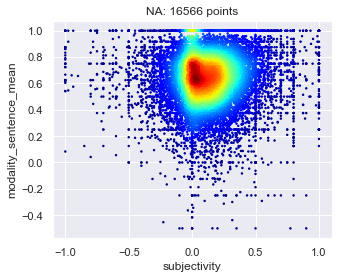

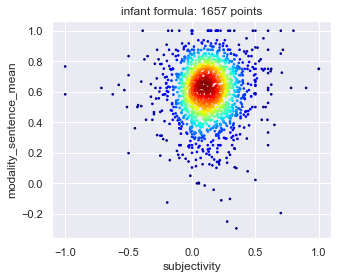

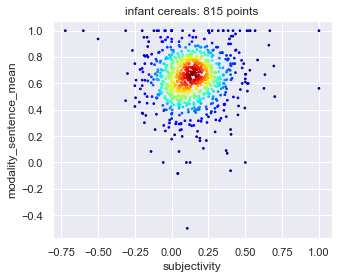

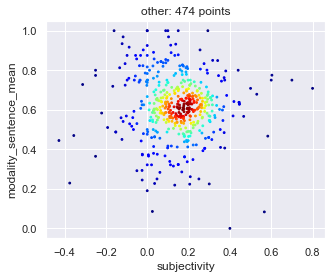

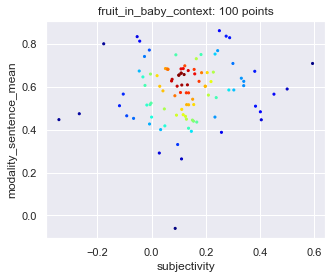

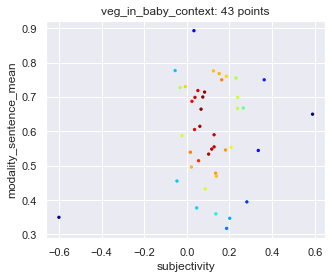

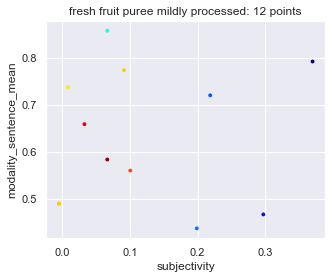

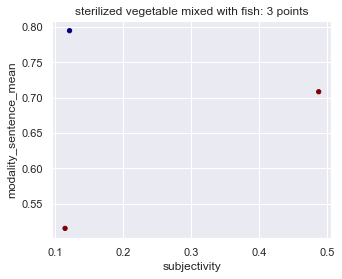

<ipython-input-60-0187a1e9abbf>:6: RuntimeWarning: divide by zero encountered in double_scalars
  size_for_cat = 20./np.log(len(num_of_posts)) #make points bigger when theres less data to show.
/usr/local/lib/python3.8/site-packages/scipy/stats/kde.py:574: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


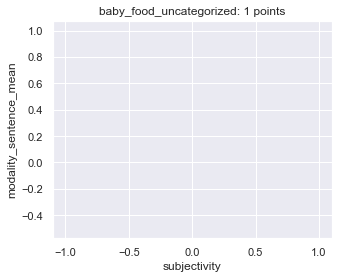

In [60]:
sns.set(rc={'figure.figsize':(5,4)})
errs = []
for category in list(class_df['product_type'].value_counts().index): #get the non-zero labels (zero labels may create an error)
    try:
        num_of_posts = class_df.loc[class_df.product_type == category]
        size_for_cat = 20./np.log(len(num_of_posts)) #make points bigger when theres less data to show.
        heat_scatter(num_of_posts, 'modality_sentence_mean','subjectivity', point_size=size_for_cat)
        plt.title(category + ': %s points' % len(num_of_posts))
        plt.show()
    except ValueError:
        print(category + ': insufficient data')
    except Exception as exc:
        errs.append(category + ' ' + str(exc))
        errs.append(str(traceback.format_exc()))
print('\n'.join(errs))

<ipython-input-61-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in log
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.


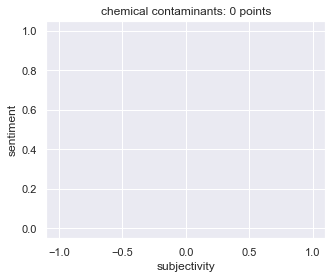

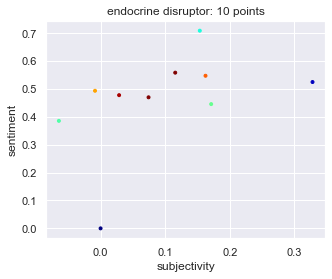

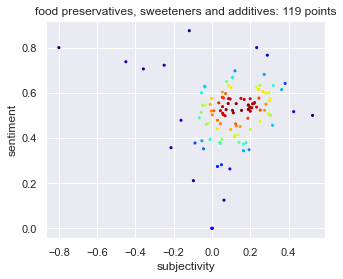

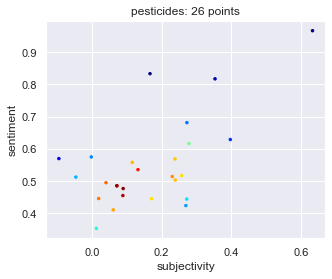

<ipython-input-61-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in log
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.


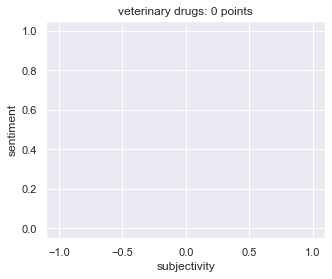

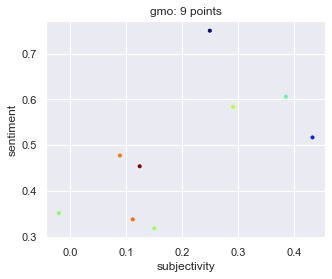

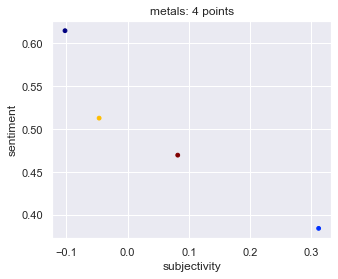

<ipython-input-61-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in log
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.


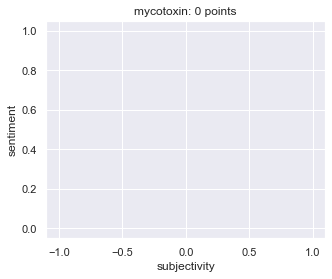

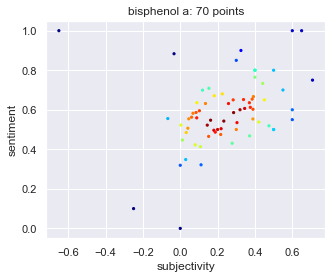

<ipython-input-61-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in log
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.


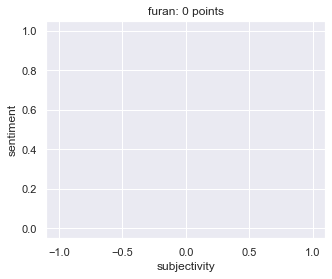

<ipython-input-61-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in double_scalars
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.
/usr/local/lib/python3.8/site-packages/scipy/stats/kde.py:574: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


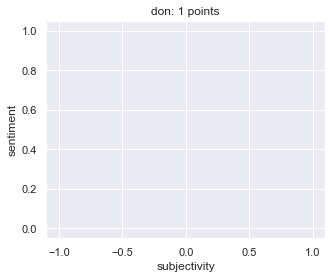

<ipython-input-61-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in double_scalars
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.
/usr/local/lib/python3.8/site-packages/scipy/stats/kde.py:574: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


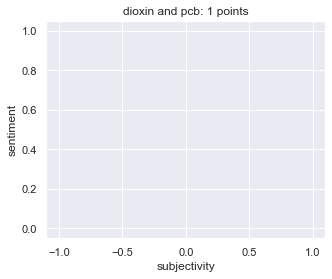

<ipython-input-61-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in log
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.


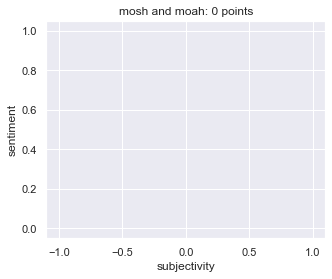

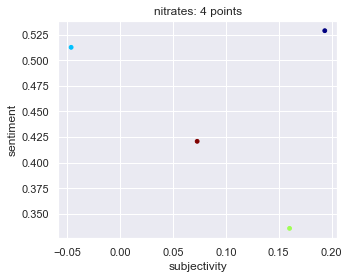

<ipython-input-61-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in log
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.


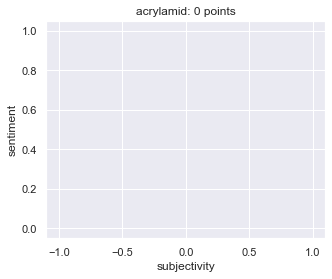

/usr/local/lib/python3.8/site-packages/scipy/stats/kde.py:263: RuntimeWarning: divide by zero encountered in true_divide
  result = result / self._norm_factor


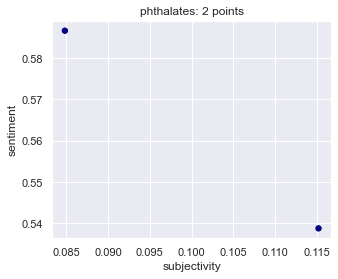

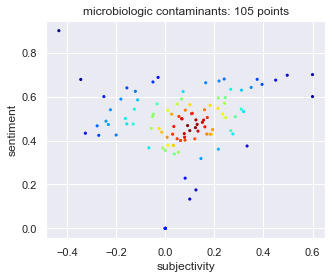

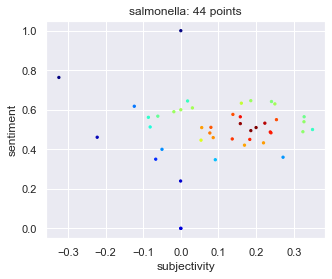

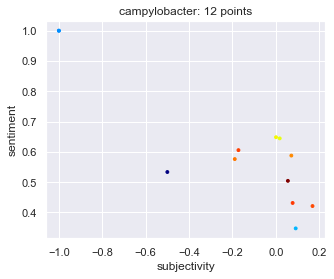

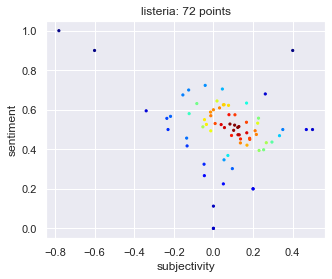

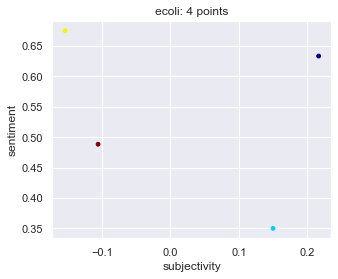

<ipython-input-61-d171e6ff4ca9>:5: RuntimeWarning: divide by zero encountered in double_scalars
  size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.
/usr/local/lib/python3.8/site-packages/scipy/stats/kde.py:574: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


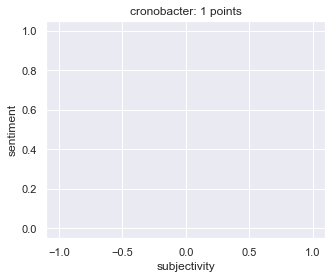

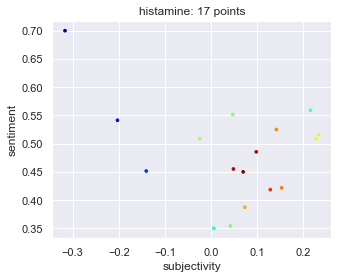

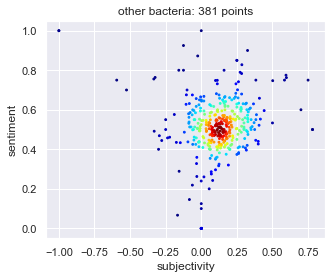

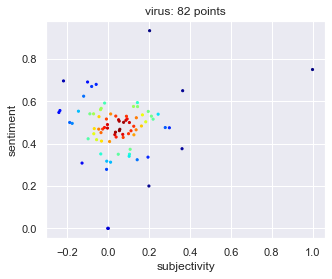

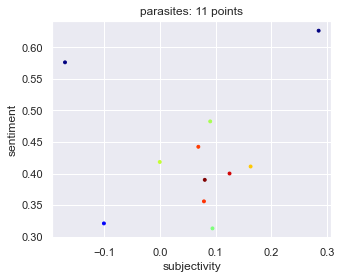

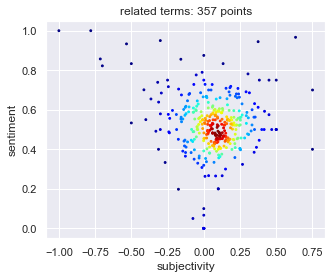

In [61]:
errs = []
for haz in hazards.keys():
    posts_for_hazard = class_df.loc[(class_df[haz] > 0)]
    try:
        size_for_cat = 20./np.log(len(posts_for_hazard)) #make points bigger when theres less data to show.
        heat_scatter(posts_for_hazard, 'sentiment','subjectivity', point_size=size_for_cat)
        plt.title(haz + ': %s points' % len(posts_for_hazard))
        plt.show()
    except ValueError:
        print(haz + ': insufficient data')
    except Exception as exc:
        errs.append(haz + ' ' + str(exc))
        errs.append(str(traceback.format_exc()))
print('\n'.join(errs))

# Sentiment (Pos/Neg) by Product

In [62]:
keys, modalities_by_sentence = zip(*[(key, parse_and_get_m(posts_dict[key]['body'])) for key in class_df.index])
#temp=  pd.Series(modalities_by_sentence, index=keys) #DEBUG

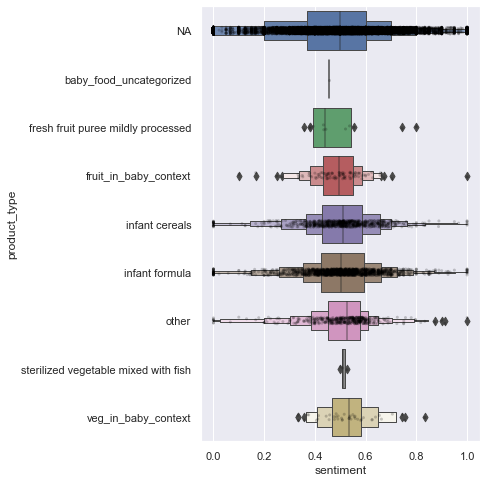

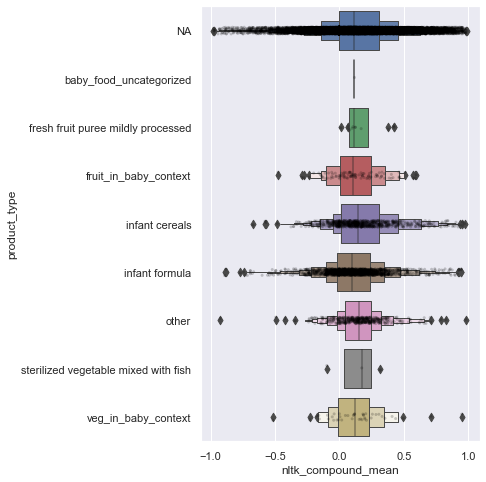

In [63]:
sns.set(rc={'figure.figsize':(5,8)})
sns.boxenplot(x='sentiment', y='product_type', data=class_df, k_depth = 'trustworthy' ) #most are sizes are quite large so it doesnt hurt to use this.
sns.stripplot(x='sentiment', y='product_type', data=class_df, color='black', alpha=0.2, jitter=0.07, size=3) #to give an idea of the sample size
plt.show()
sns.boxenplot(x='nltk_compound_mean', y='product_type', data=class_df, k_depth = 'trustworthy' ) #most are sizes are quite large so it doesnt hurt to use this.
sns.stripplot(x='nltk_compound_mean', y='product_type', data=class_df, color='black', alpha=0.2, jitter=0.07, size=3) #to give an idea of the sample size
plt.show()

#boxplot outlier detection:
#using a method that is a function of the inter-quartile range.
#https://seaborn.pydata.org/generated/seaborn.boxplot.html#seaborn.boxplot

# T-Test, F-Test & Boxplots

## Explanations & Setup Code

### Boxplots with NA as baseline
* note that NA / non-classified posts are going to exhibit their own biases
    * general tone of posts on netmums (polite, cordial, friendyl, casual) 
    * these posts are in threads which mention at least one post with a hazard & a product in it (possible negative bias?)

## T-Test & F-Test by Hazard

### F-Tests:

Let x1, x2, . . . , xn and y1, y2, . . . , ym be independent random samples from normal distributions with means μX and μY and standard deviations σX and σY , respectively.

a. To test H0: $σ_X^2 = σ_Y^2$ versus H1: $σ_X^2 > σ_Y^2$ at the α level of significance, reject H0 if $s_Y^2/s_X^2 \leq F_{α,m−1,n−1} $.


b. To test H0: $σ_X^2 = σ_Y^2$ versus H1: $σ_X^2 < σ_Y^2$ at the α level of significance, reject H0 if
$s_Y^2/s_X^2 \geq F_{1−α,m−1,n−1} $.

c. To test H0: $σ_X^2 = σ_Y^2$ versus H1: $σ_X^2 ̸= σ_Y^2$ at the α level of significance, reject H0 if
$s_Y^2 /s_X^2$ is either 

* $\leq F_{α/2,m−1,n−1}$
* $\geq F_{1−α/2,m−1,n−1} $.

alternate version of c: we instead take max of sY/sX or sX/sY, and then check that its <= F_

In [64]:
import scipy

In [65]:
hazard_classes = list(class_df['hazard_type'].value_counts().index.drop('NA'))

In [66]:
baseline_v = np.var(class_df.loc[class_df['hazard_type'] == "NA"]['sentiment'])

m = len(class_df.loc[class_df['hazard_type'] == "NA"]['sentiment'])
n = {item:len(class_df.loc[class_df['hazard_type'] == item]['sentiment']) \
          for item in hazard_classes}

In [67]:
#Definition of Two-Tail F Test: (H0: variance is equal to baseline)
# var(x) / var(y) where x is the item with the larger variance

#Definition of One-Tail F Test (where H0: variance is = or higher than baseline):
# var(x) / var(y) where x is BASELINE

F_Test = {item:np.var(class_df.loc[class_df['hazard_type'] == item]['sentiment']) \
          for item in hazard_classes}

#One-Sided F-Test
#remove zero-variance elements.
F_Test = {key: baseline_v / item for key, item in F_Test.items() if item > 0}

#Make it Two-Sided
#remove zero-variance elements.
F_Test = {key: max(value, 1./value) for key, value in F_Test.items() if value > 0}

#define rejection level
alpha = 0.05

#Test against the F distirbution at the given level
F_Test = {key:scipy.stats.f.cdf(F, m - 1, n[key]-1) for key, F in F_Test.items()}
F_Test = {key:{'Reject H0':p>1-(alpha/2),'p':p } for key, p in F_Test.items()}

In [68]:
#show results
pd.DataFrame(F_Test).transpose()

Reject H0         p
other bacteria                                    True         1
related terms                                     True         1
food preservatives, sweeteners and additives      True         1
microbiologic contaminants                        True  0.999984
virus                                             True  0.999998
bisphenol a                                       True   0.98996
listeria                                         False  0.973255
salmonella                                        True   0.97647
pesticides                                        True  0.984031
histamine                                         True  0.999934
parasites                                         True  0.997749
gmo                                              False  0.894282
campylobacter                                    False  0.682137
endocrine disruptor                              False  0.705581
metals                                           False  0.833755
ecoli                                            False  0.763224
nitrates                                         False  0.848338

### Paired T-Test
We exploit threads to do paired t-test for posts mentioning a hazard vs posts NOT mentioning a hazard (matched-pairs sample)

We pair by taking the average senitment for NA posts in a thread vs hazard-cointaining posts within a thread.

Main weakness: if threads are mainly ABOUT that hazard and NA posts just don't mention it specifically by name while still being in the context of it, then the signifance will be __underestimated__. If a hazard is mentioned once, off-topic, in a thread of a different topic then the significance of the result may be __overestimated__.

__To improve on this model it would be good to:__
* __1) Develop a metric to ensure the main topic of a thread (topic mining on titles, variance of term counts in thread..?)__
* __2) Calculate an Independent T-Test where we have a random sampling from all threads vs our selected subset. (however our entire scrape still has its own sample bias, but I do believe the entire thing is a quite noisy sample)__
* __3) Possibly correct specification of degrees of freedom, since these samples are means of other samples which means the sample size is actually larger.__


TODO: independent T-Tests on thread-averages, comparing NA-only threads vs hazard-containing threads. 
I want to select only threads where a hazard is mentioned in the title/more than once/etc but 1) kind of p-hacky and 2) sounds like it will limite data a LOT!

#### Data Prep

In [69]:
#we are trying to get the threads for which we can run a paired t-test
#we can't use index.levels[0] because that just returns the indexes form the original, not the view.
threads_with_NA = set(list(zip(*list(class_df.loc[class_df['hazard_type'] == 'NA'].index)))[0])
threads_without_NA = set(list(zip(*list(class_df.loc[class_df['hazard_type'] != 'NA'].index)))[0])
print(len(threads_without_NA - threads_with_NA), len(threads_with_NA - threads_without_NA))

0 61


^ from above, we know that ALL threads have NA classed posts. But not all threads have well-classified posts.
For the paired T-Test we will just use the threads which contain non-NA posts.

note that in total there are 510 unique threads. and now we will drop 61 of them.

In [70]:
paired_df = class_df.loc[threads_without_NA].copy() #the df without unneeded threads.

In [71]:
#get means grouped by thread & classification
paired_df = paired_df.reset_index().groupby(by = ['hazard_type', 'level_0']).mean().dropna()
paired_df = paired_df.reset_index().set_index('level_0')

In [72]:
#create a dict of paired values for plotting. 
#This needs to be created only once (as long as all relevant variables have been added to dataframe)

#structure of dict:
#{term: (dataframe of values from term with thread as index, dataframe of values of NA with the same index)
#term:...
#}

paired_values = {}
for label in paired_df['hazard_type'].value_counts().index.drop('NA'):
    relevant_index = paired_df.loc[paired_df['hazard_type'] == label].index
    paired_values[label] = (paired_df.loc[paired_df['hazard_type'] == label], \
                           paired_df.loc[paired_df['hazard_type'] == 'NA'].loc[relevant_index])
    

In [73]:
{key:len(i[0]) for key, i in paired_values.items()}

{'related terms': 167,
 'other bacteria': 161,
 'food preservatives, sweeteners and additives': 64,
 'microbiologic contaminants': 48,
 'virus': 44,
 'listeria': 33,
 'salmonella': 23,
 'pesticides': 16,
 'histamine': 13,
 'parasites': 8,
 'gmo': 7,
 'endocrine disruptor': 7,
 'campylobacter': 6,
 'bisphenol a': 6,
 'metals': 3,
 'ecoli': 3,
 'nitrates': 2,
 'phthalates': 1,
 'don': 1,
 'cronobacter': 1}

### Sentiment (Pos/Neg) by Hazard

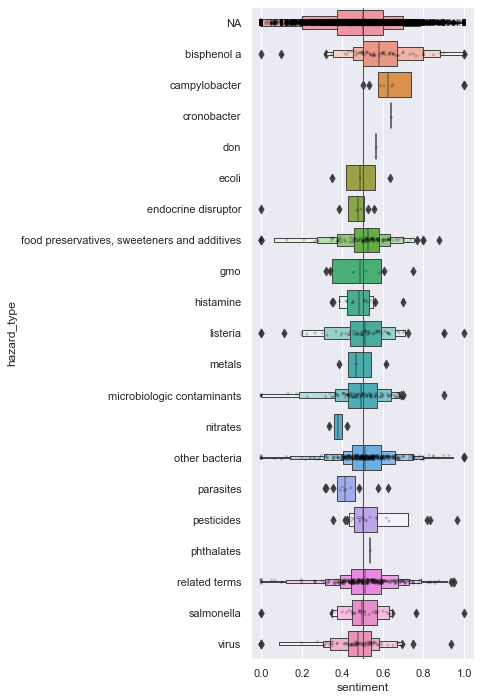

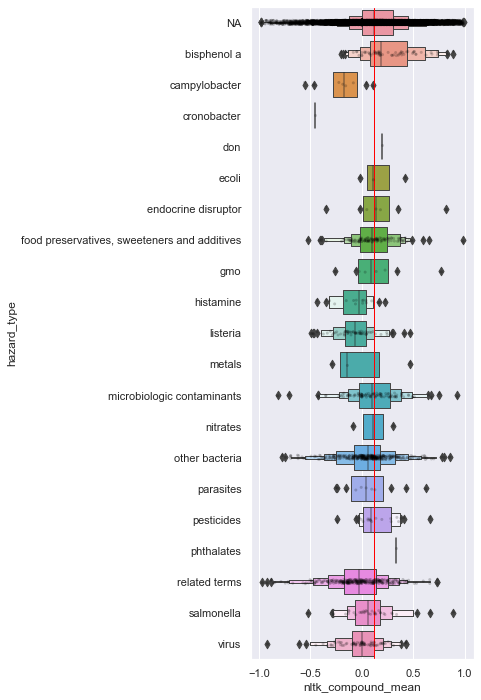

In [74]:
#sns.set(rc={'figure.figsize':(4,12)})
#sns.boxenplot(x='sentiment', y='hazard_type', data=class_df)
#plt.show()
#sns.boxenplot(x='nltk_compound_mean', y='hazard_type', data=class_df)
#plt.show()

sns.set(rc={'figure.figsize':(4,12)})
sns.boxenplot(x='sentiment', y='hazard_type', data=class_df, k_depth = 'trustworthy' ) #most are sizes are quite large so it doesnt hurt to use this.
sns.stripplot(x='sentiment', y='hazard_type', data=class_df, color='black', alpha=0.2, jitter=0.07, size=3) #to give an idea of the sample size
#vertical line at 50% quantile of NA, as a baseline
plt.axvline(np.quantile(class_df.loc[class_df['hazard_type'] == 'NA']['sentiment'],0.5), 0, c='red', linewidth=1)
plt.show()
sns.boxenplot(x='nltk_compound_mean', y='hazard_type', data=class_df, k_depth = 'trustworthy' ) #most are sizes are quite large so it doesnt hurt to use this.
sns.stripplot(x='nltk_compound_mean', y='hazard_type', data=class_df, color='black', alpha=0.2, jitter=0.07, size=3) #to give an idea of the sample size
#vertical line at 50% quantile of NA, as a baseline
plt.axvline(np.quantile(class_df.loc[class_df['hazard_type'] == 'NA']['nltk_compound_mean'].dropna(),0.5), 0, c='red', linewidth=1)
plt.show()

It may seem strange that these terms have positive sentiment. Keep in mind that we are looking at the sentiment in the entire post where the term occurs, and people are netmums are quite often very friendly to each other when replying.

#TODO: use only subset of terms around the phrases! (non-per  post approach probablY)

### Pattern Sent: T-Test & F-Test by Hazard

#### Check if normally distributed (visual check)

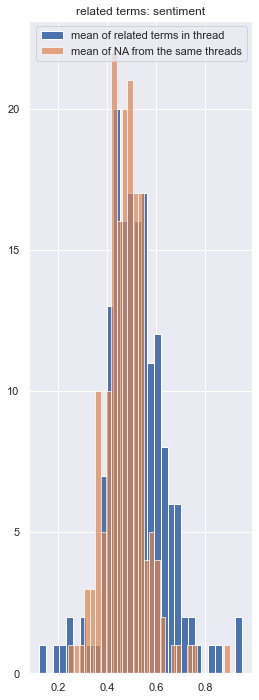

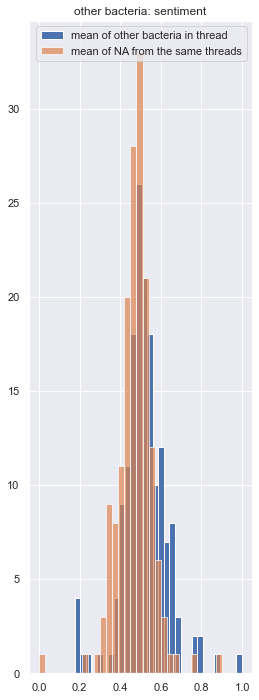

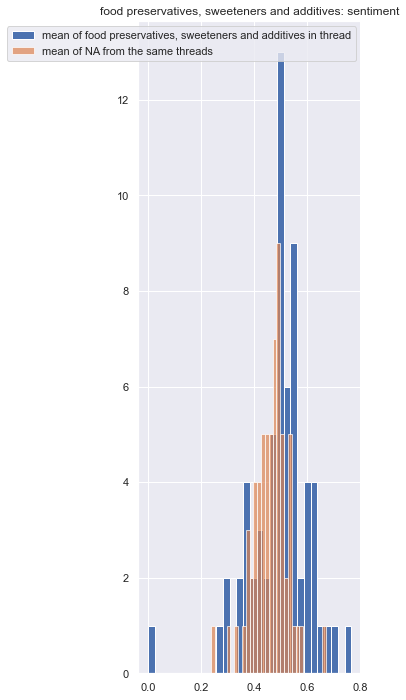

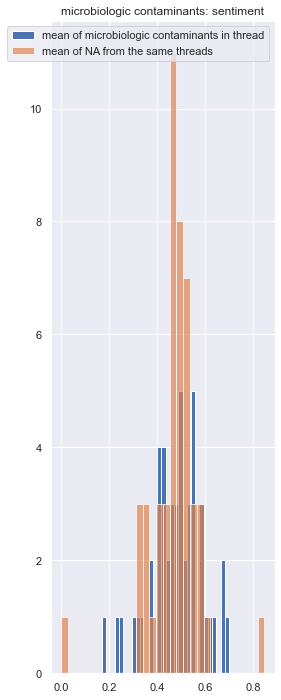

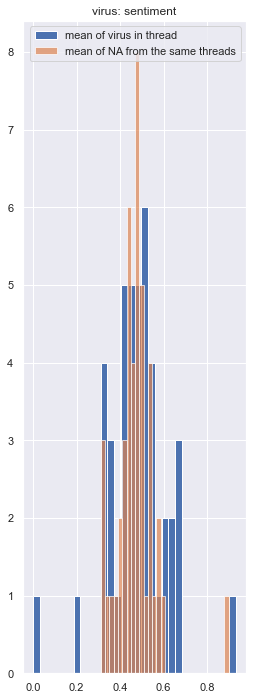

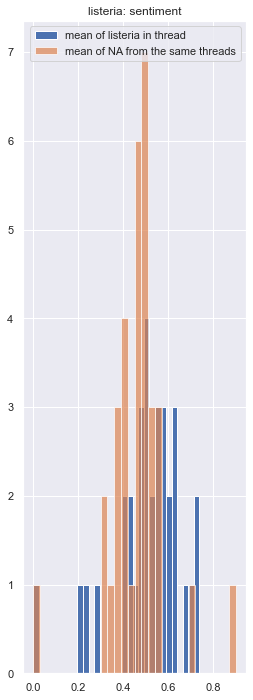

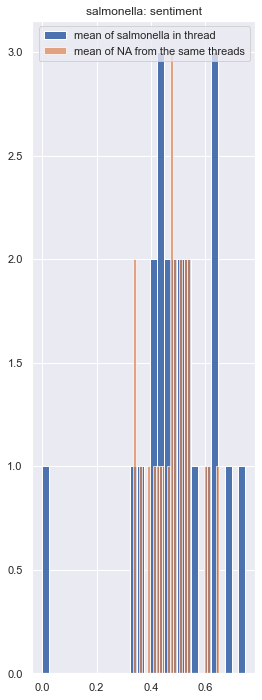

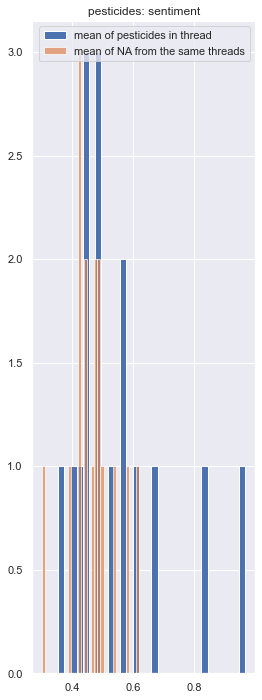

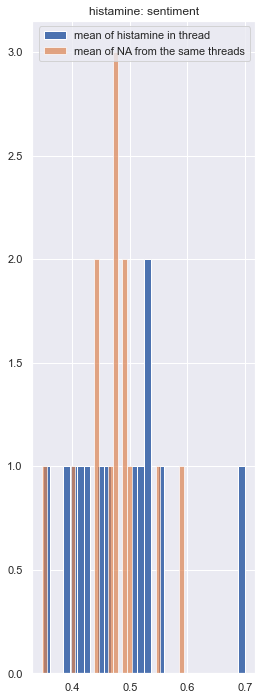

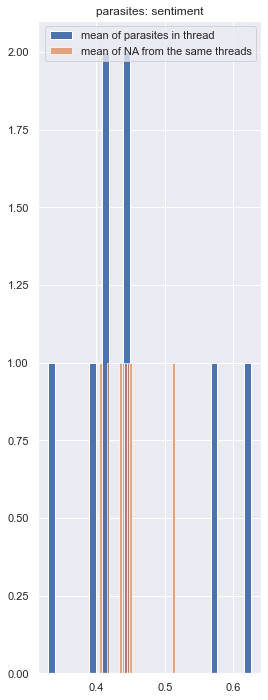

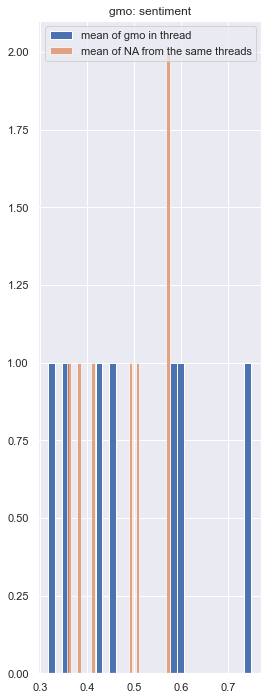

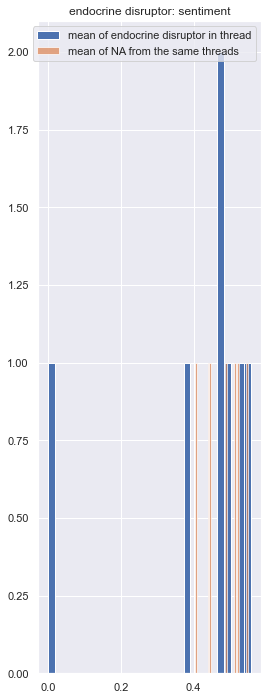

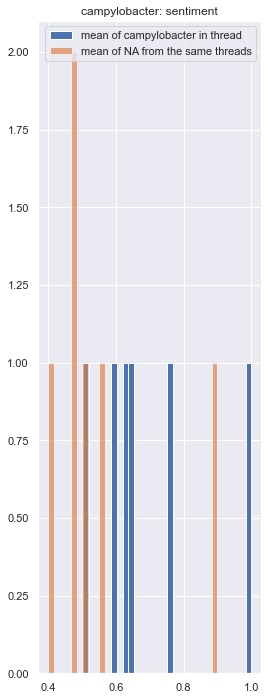

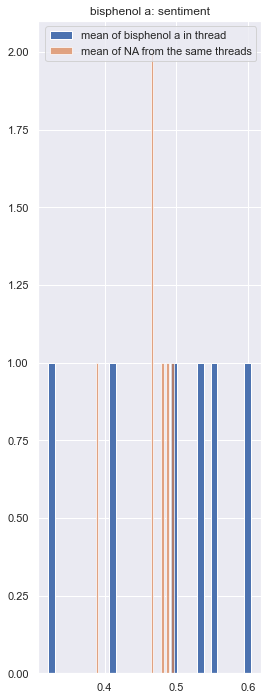

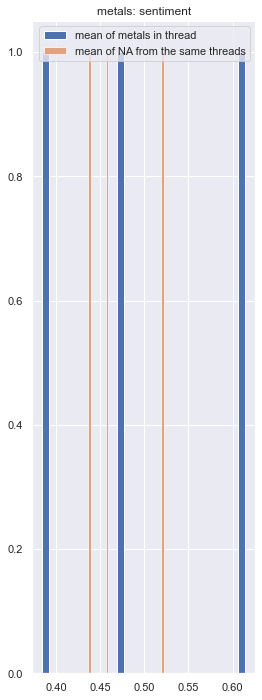

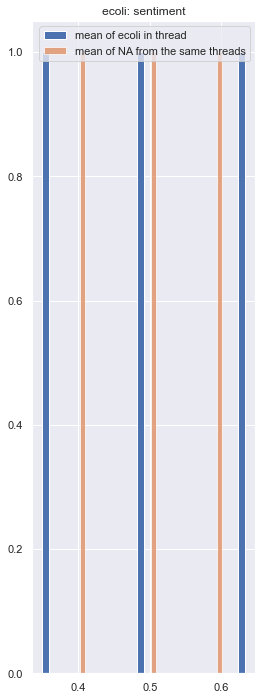

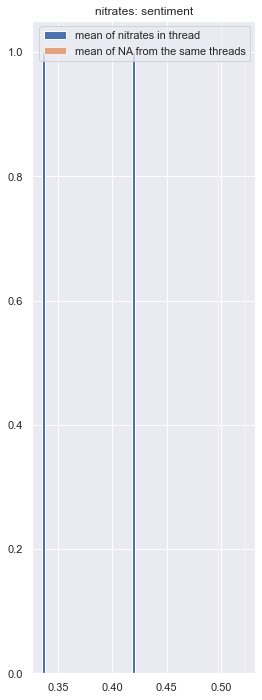

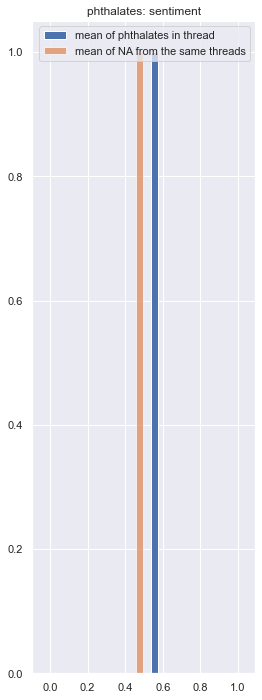

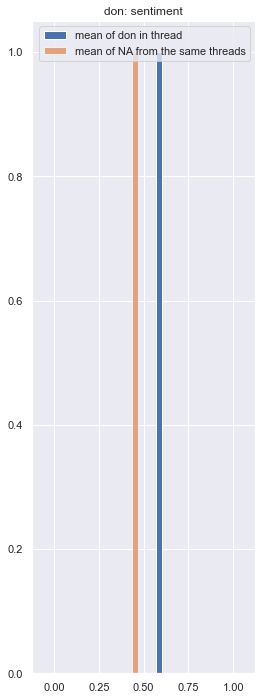

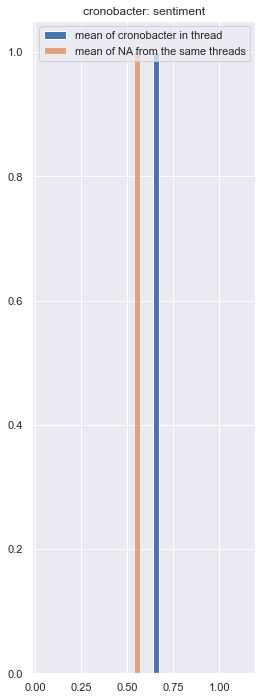

In [75]:
#check that the data are normally distributed
sns.set(rc={'figure.figsize':(5,4)})
for label in paired_df['hazard_type'].value_counts().index.drop('NA'):
    plt.hist(paired_values[label][0]['sentiment'], bins=30)
    plt.hist(paired_values[label][1]['sentiment'], bins = 30, alpha=0.7)
    plt.title('%s: sentiment' % label)
    plt.legend(['mean of %s in thread' % label ,'mean of NA from the same threads'])
    plt.show()

For larger sample sizes our data looks roughly normally distributed. It is then reasonable to assume with this prior knowledge that the other terms should also follow a normal distribution.

In [76]:
#Paired and Independent T-Test.
#Independent T-Test (assumes independence...)
#TODO: for this one I want to get some data from OTHER threads, as it will be more independent.
baseline_mean = None #TODO Independent T-Test

#Paired
def get_paired_t_tests(paired_data:dict, col:str, perm=None):
    """ get paired t tests for NA vs type
    data is a dict of dataframes as seen above, same structure.
    col is the column to grab form the dataframes
    """

    testit = scipy.stats.ttest_rel #maybe run a tad faster, lol..
    return {key: testit(value[0][col], value[1][col]) for key, value in paired_data.items()}

#Style-Related Functions

def highlight_signif_rows(s, props=''):
    """
    function for use with pandas styler. if a cell contains True then the entire row/column will be made green
    """
    #only works with axis specified as 1 or 0 
    check = np.where(s == True, True, False)
    if True in check:
        return np.repeat(props,len(s))
    else:
        return np.repeat('', len(s))
    
    
def display_t_test(highlight = True):
    """
    needs global vars T_Test:df and alpha:str to exist.
    """
    display_df = pd.DataFrame(T_Test).transpose().rename({0:'T-Statistic',1:'p-value (two-sided)'}, axis=1)
    colname = 'Reject H0 (two sided) at alpha %s' % alpha
    display_df[colname] = display_df['p-value (two-sided)'] > alpha #FIXME: I'm not 100% sure about > or <. Maybe read how they did the p value or review my book.
    if highlight:
        return display_df.style.apply(highlight_signif_rows, props='background-color:lightgreen', axis=1)
    else:
        return display_df

In [77]:
T_Test = get_paired_t_tests(paired_values, 'sentiment')
display_t_test()

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### NLTK Sent: T-Test & F-Test by Hazard

#### Check if normally distributed (visual check)

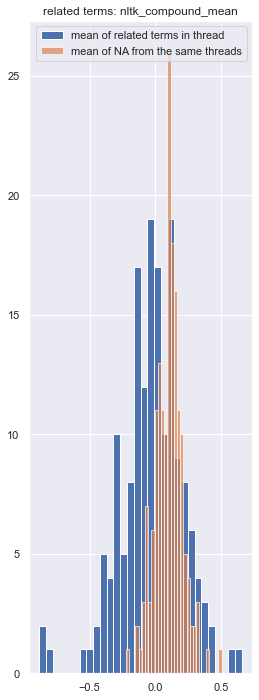

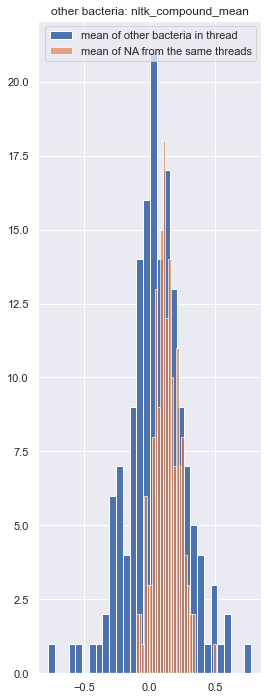

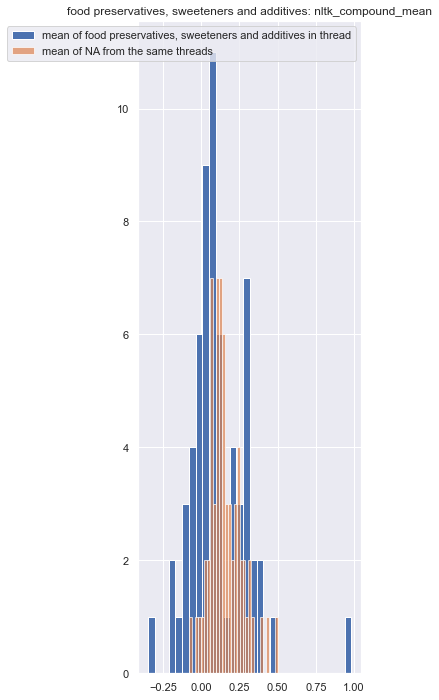

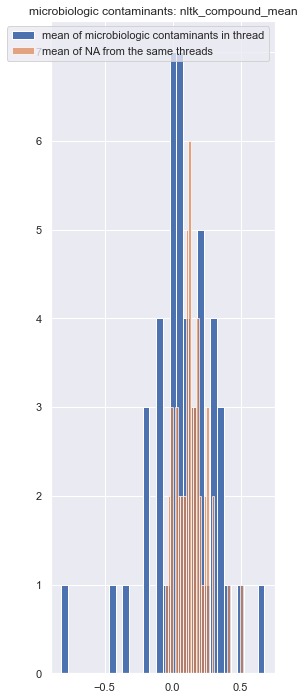

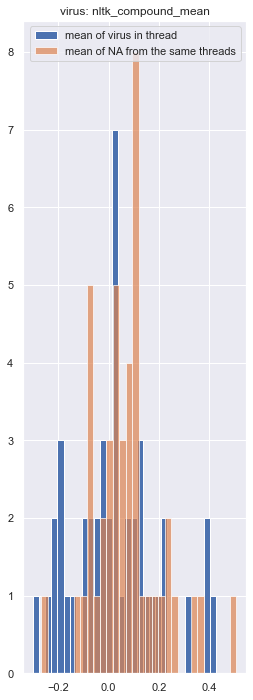

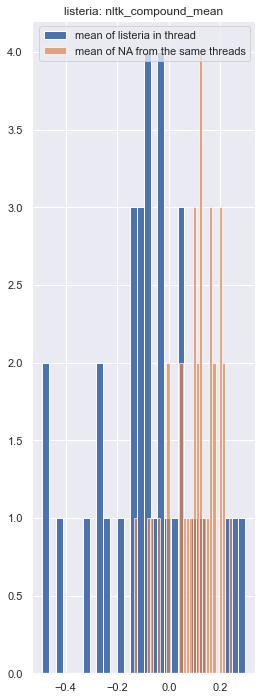

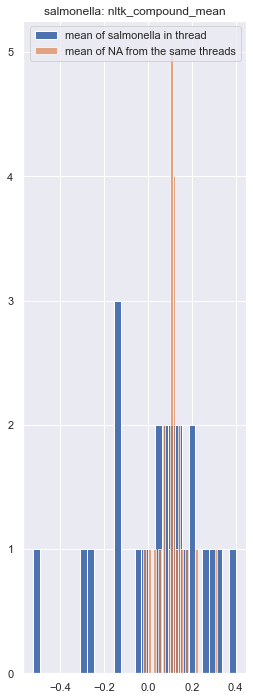

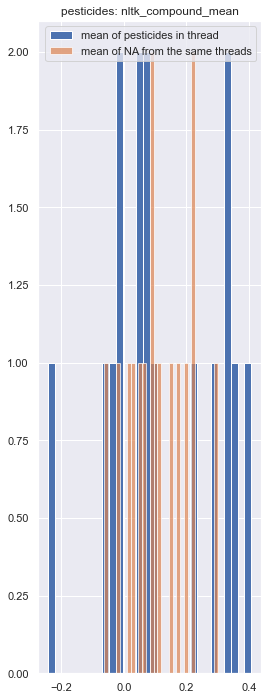

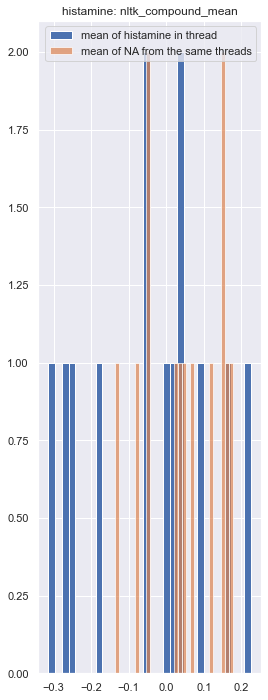

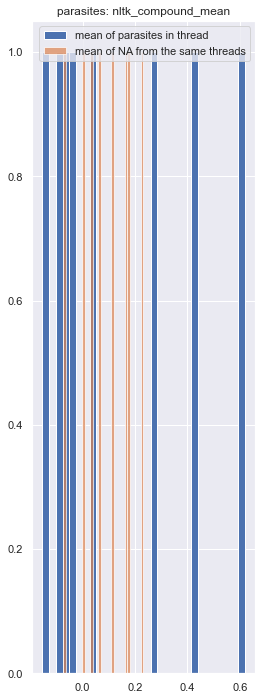

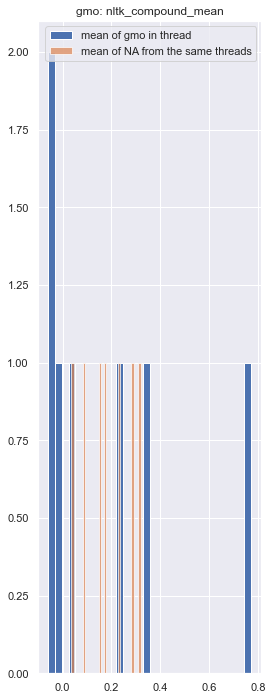

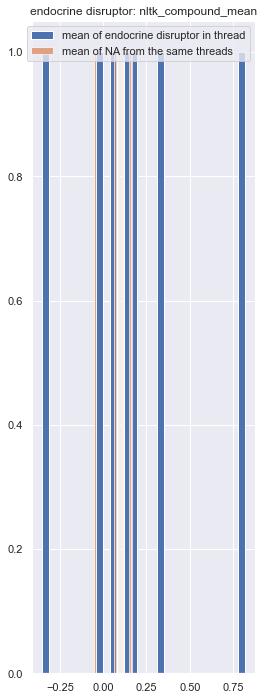

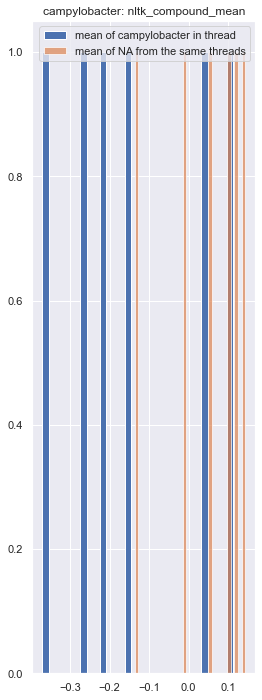

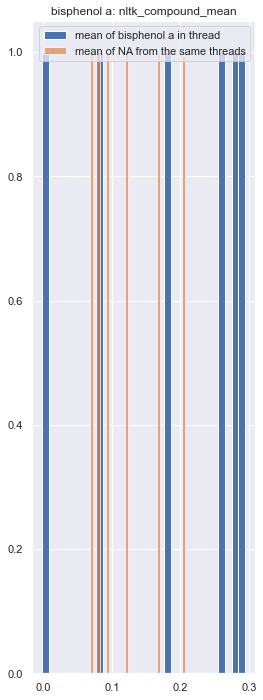

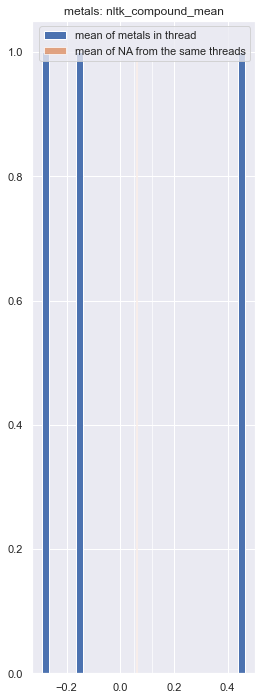

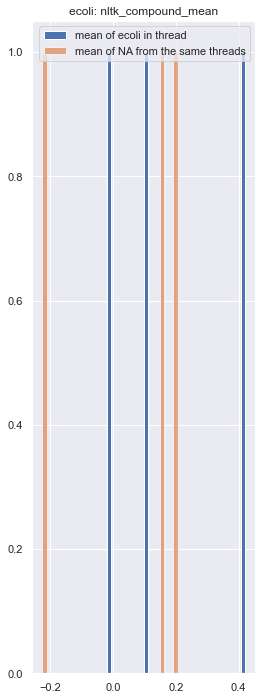

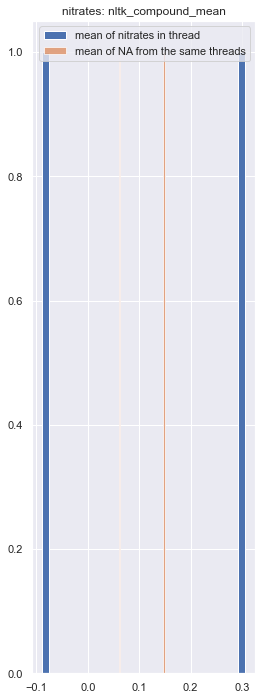

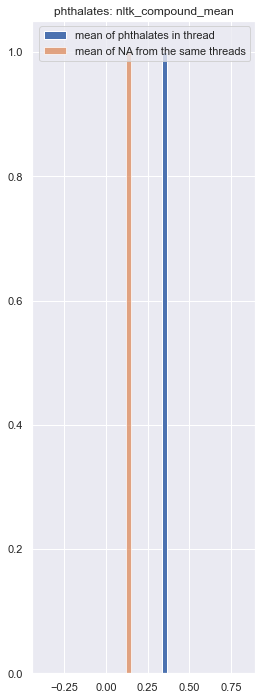

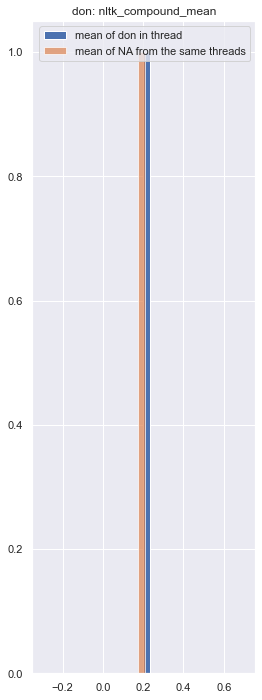

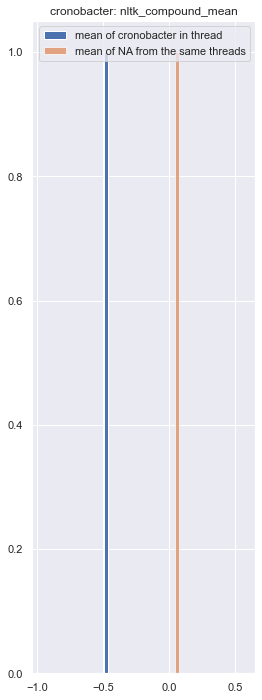

In [78]:
#check that the data are normally distributed
sns.set(rc={'figure.figsize':(5,4)})
for label in paired_df['hazard_type'].value_counts().index.drop('NA'):
    plt.hist(paired_values[label][0]['nltk_compound_mean'], bins=30)
    plt.hist(paired_values[label][1]['nltk_compound_mean'], bins = 30, alpha=0.7)
    plt.title('%s: nltk_compound_mean' % label)
    plt.legend(['mean of %s in thread' % label ,'mean of NA from the same threads'])
    plt.show()

#### F Test

In [79]:
F_Test = {item:np.var(class_df.loc[class_df['hazard_type'] == item]['nltk_compound_mean']) \
          for item in hazard_classes}

#One-Sided F-Test
#remove zero-variance elements.
F_Test = {key: baseline_v / item for key, item in F_Test.items() if item > 0}

#Make it Two-Sided
#remove zero-variance elements.
F_Test = {key: max(value, 1./value) for key, value in F_Test.items() if value > 0}

#define rejection level
alpha = 0.05

#Test against the F distirbution at the given level
F_Test = {key:scipy.stats.f.cdf(F, m - 1, n[key]-1) for key, F in F_Test.items()}
F_Test = {key:{'Reject H0':p>1-(alpha/2),'p':p } for key, p in F_Test.items()}

In [80]:
#show results
pd.DataFrame(F_Test).transpose()

Reject H0         p
other bacteria                                    True  0.999988
related terms                                     True         1
food preservatives, sweeteners and additives     False  0.485118
microbiologic contaminants                        True  0.992869
virus                                            False  0.559407
bisphenol a                                       True  0.976483
listeria                                         False  0.850894
salmonella                                       False  0.883518
pesticides                                       False  0.716678
histamine                                        False  0.813741
parasites                                        False  0.701572
gmo                                              False  0.771676
campylobacter                                    False  0.477652
endocrine disruptor                              False  0.848797
metals                                           False  0.629013
ecoli                                            False  0.500736
nitrates                                         False  0.375491

#### Paired T-Test

In [81]:
T_Test = get_paired_t_tests(paired_values, 'nltk_compound_mean')
display_t_test()

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [82]:
##define a function which is useful for making nice box plots
#points are displayed to make viewer more aware of small sample sizes

def boxstrip(x_name:str, y_name:str, df=class_df):
    """
    x some continuous or integer data, y some category which contains a cat 'NA'
    """
    sns.boxplot(x=x_name, y=y_name, data=df, fliersize=0, linewidth=1)
    #sns.boxenplot(x='subjectivity', y='hazard_type', data=class_df, k_depth='full', showfliers=False)
    sns.stripplot(x=x_name, y=y_name, data=df, color='black', alpha=0.8, jitter=0.07, size=3)
    #vertical line at 50% quantile of NA, as a baseline
    plt.axvline(np.quantile(class_df.loc[df[y_name] == 'NA'][x_name],0.5), 0, c='red', linewidth=1)

## Subjectivity

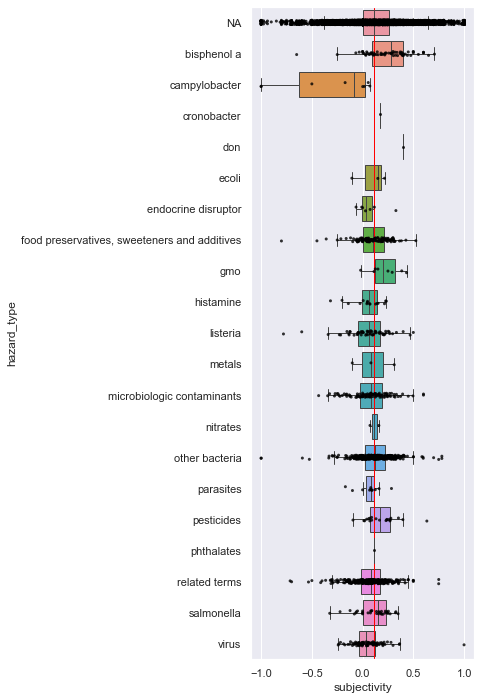

In [83]:
sns.set(rc={'figure.figsize':(4,12)})
boxstrip('subjectivity', 'hazard_type')

TODO: write comments about this

### Subjectivity: T-Test & F-Test by Hazard

#### Check if normally distributed (visual check)

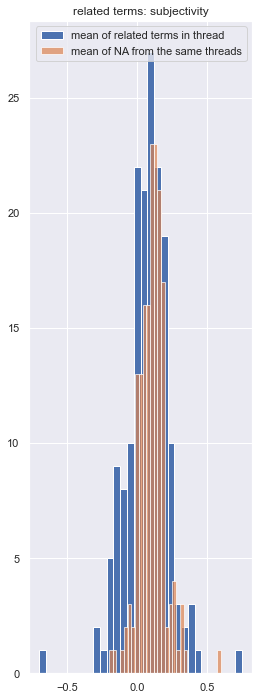

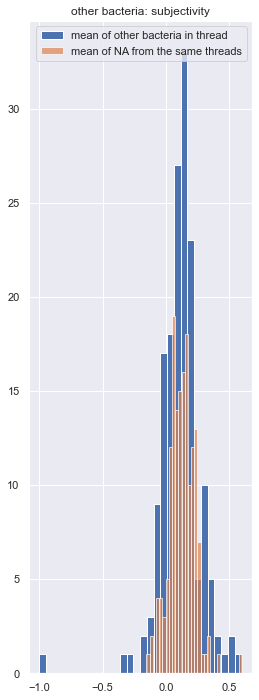

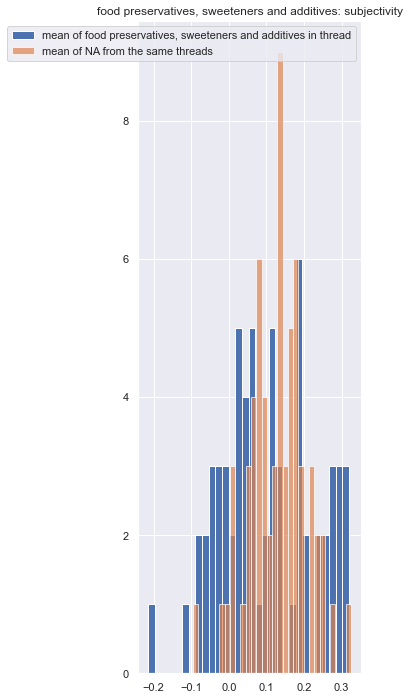

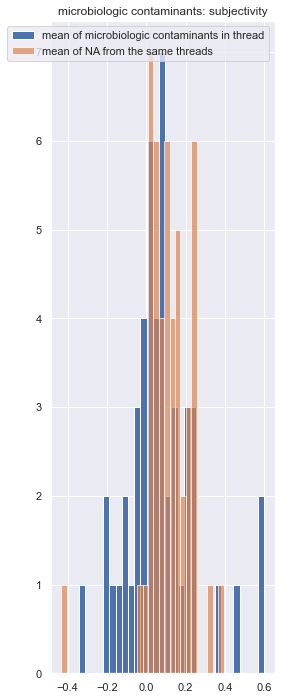

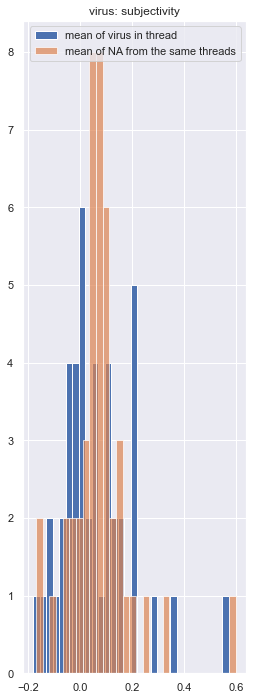

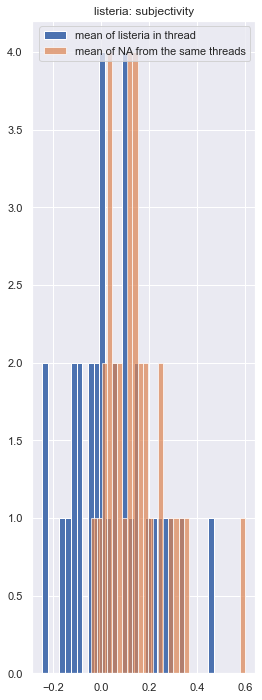

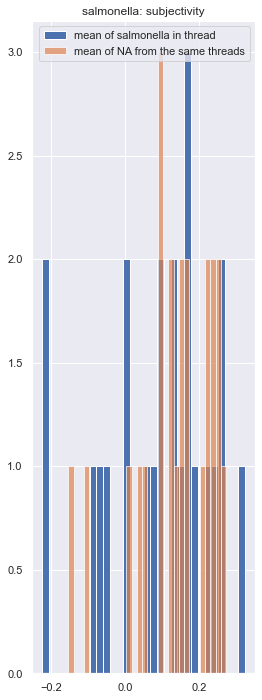

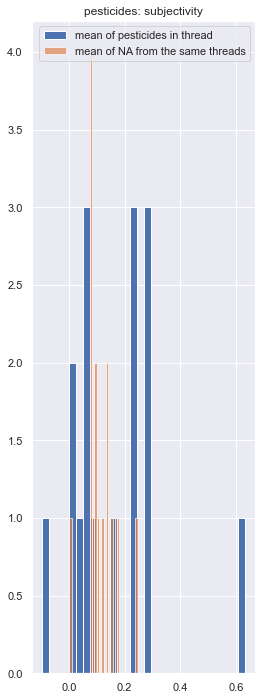

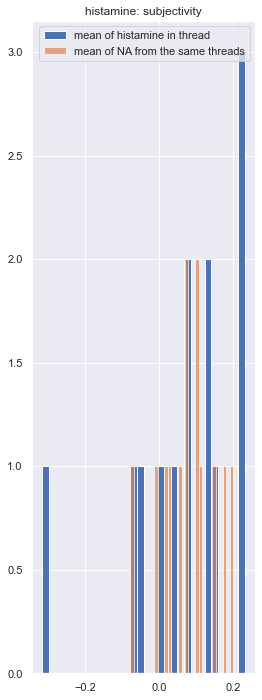

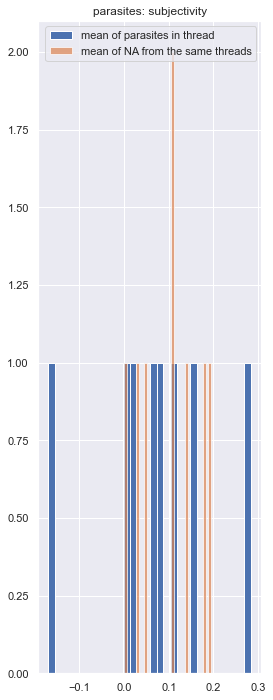

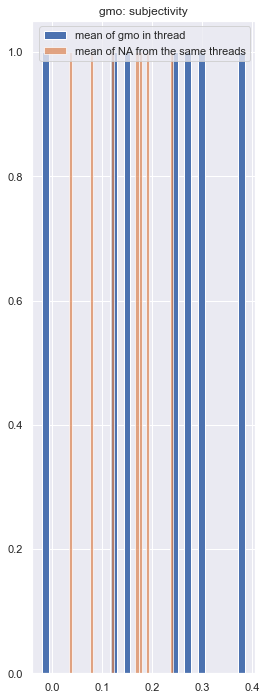

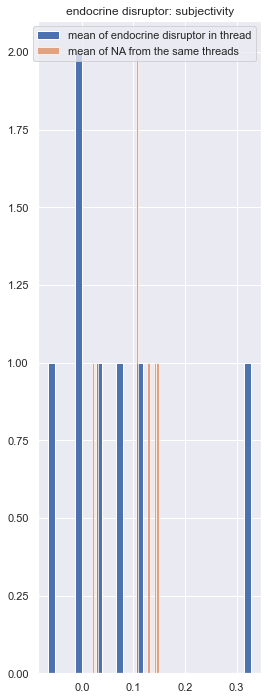

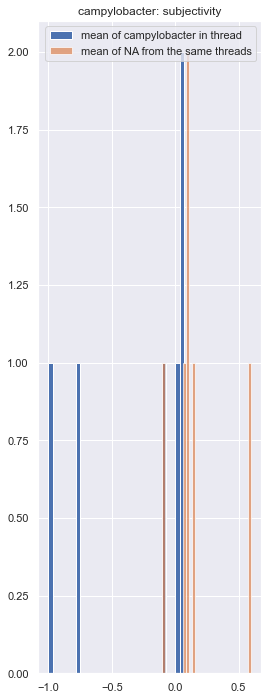

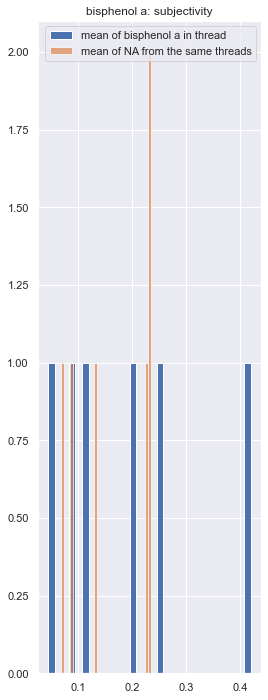

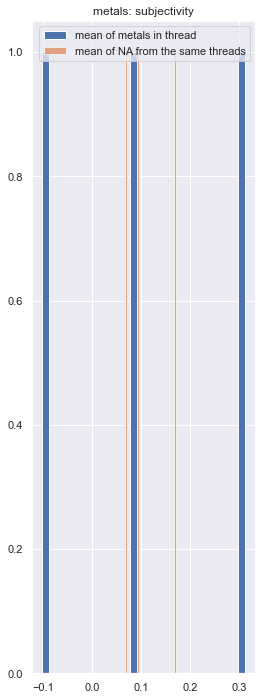

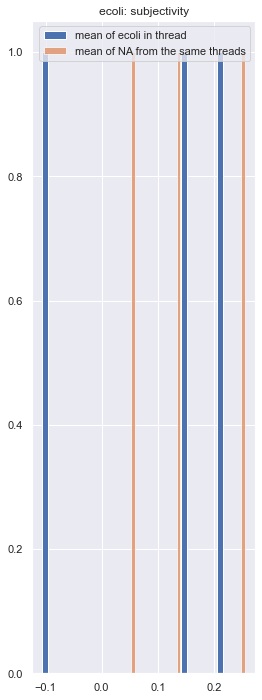

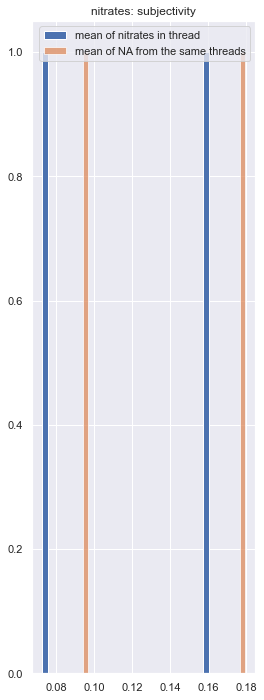

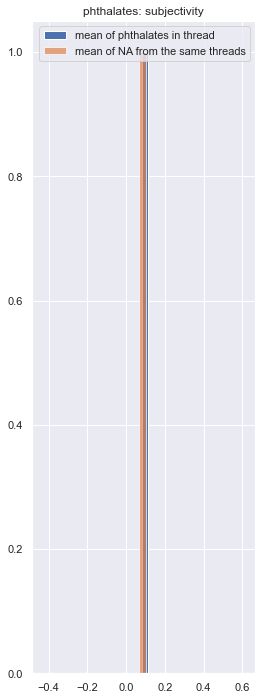

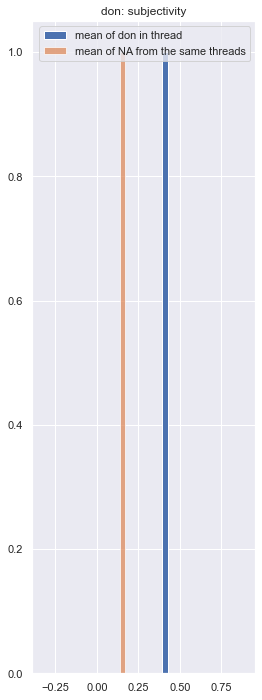

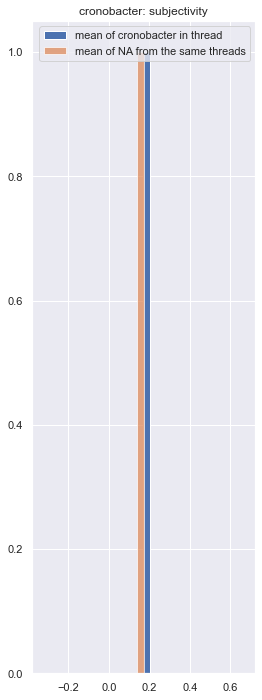

In [84]:
#check that the data are normally distributed
sns.set(rc={'figure.figsize':(5,4)})
for label in paired_df['hazard_type'].value_counts().index.drop('NA'):
    plt.hist(paired_values[label][0]['subjectivity'], bins=30)
    plt.hist(paired_values[label][1]['subjectivity'], bins = 30, alpha=0.7)
    plt.title('%s: subjectivity' % label)
    plt.legend(['mean of %s in thread' % label ,'mean of NA from the same threads'])
    plt.show()

#### F Test

In [85]:
F_Test = {item:np.var(class_df.loc[class_df['hazard_type'] == item]['subjectivity']) \
          for item in hazard_classes}

#One-Sided F-Test
#remove zero-variance elements.
F_Test = {key: baseline_v / item for key, item in F_Test.items() if item > 0}

#Make it Two-Sided
#remove zero-variance elements.
F_Test = {key: max(value, 1./value) for key, value in F_Test.items() if value > 0}

#define rejection level
alpha = 0.05

#Test against the F distirbution at the given level
F_Test = {key:scipy.stats.f.cdf(F, m - 1, n[key]-1) for key, F in F_Test.items()}
F_Test = {key:{'Reject H0':p>1-(alpha/2),'p':p } for key, p in F_Test.items()}

In [86]:
#show results
pd.DataFrame(F_Test).transpose()

Reject H0         p
other bacteria                                    True  0.999884
related terms                                     True  0.999934
food preservatives, sweeteners and additives      True  0.999541
microbiologic contaminants                       False  0.966179
virus                                             True  0.999378
bisphenol a                                      False  0.510658
listeria                                         False  0.667607
salmonella                                        True  0.995883
pesticides                                       False  0.964468
histamine                                        False  0.962223
parasites                                         True  0.986687
gmo                                              False  0.898068
campylobacter                                    False  0.967141
endocrine disruptor                              False  0.943212
metals                                           False  0.560555
ecoli                                            False   0.67696
nitrates                                         False  0.844324

#### Paired T-Test

In [87]:
T_Test = get_paired_t_tests(paired_values, 'subjectivity')
display_t_test()

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Modality

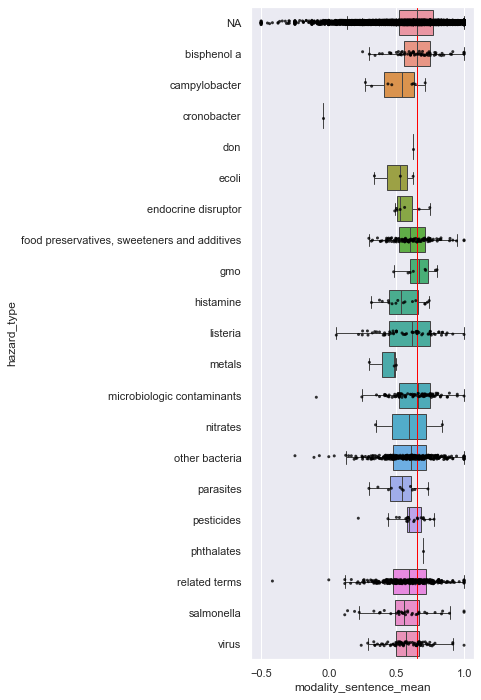

In [88]:
sns.set(rc={'figure.figsize':(4,12)})
boxstrip('modality_sentence_mean','hazard_type')

We can see that compared to posts without hazard terms (NA), posts with hazards mentioned tend to have lower confidence in what they are saying.

note: data for DON is extremely small. It is only one observation which by checking manually, I can confirm is not relevant (it is a typo of don't )
Cronobacter is also only one observation.

### Modality: T-Test & F-Test by Hazard

#### Check if normally distributed (visual check)

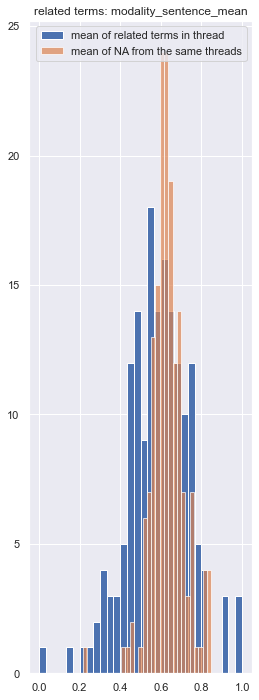

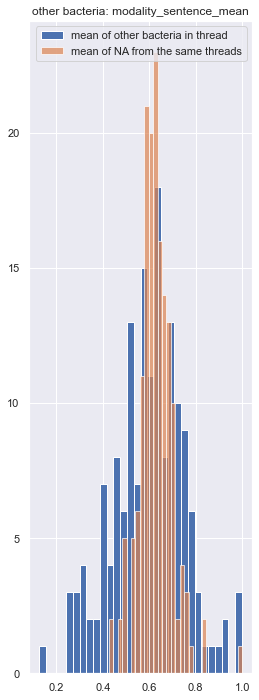

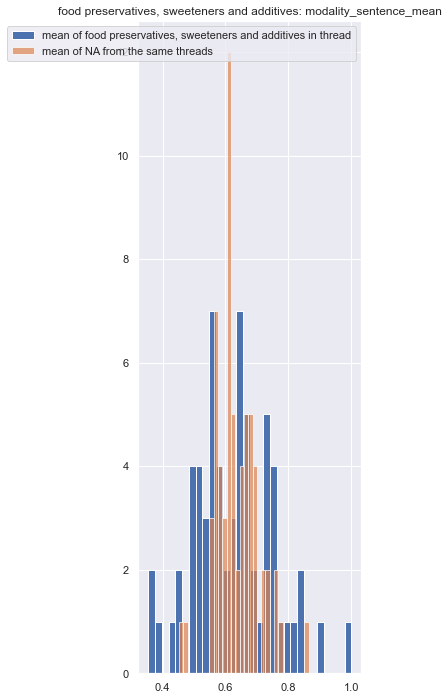

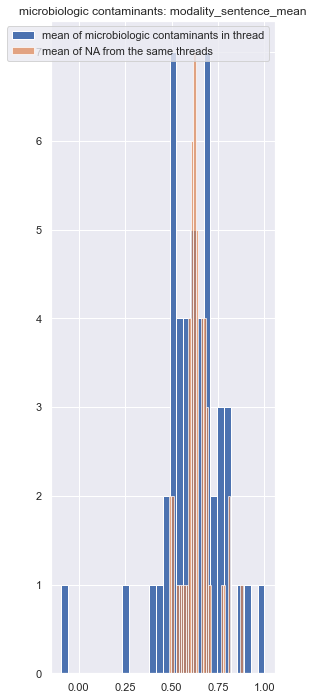

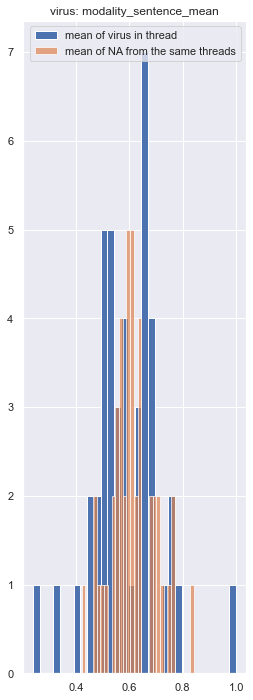

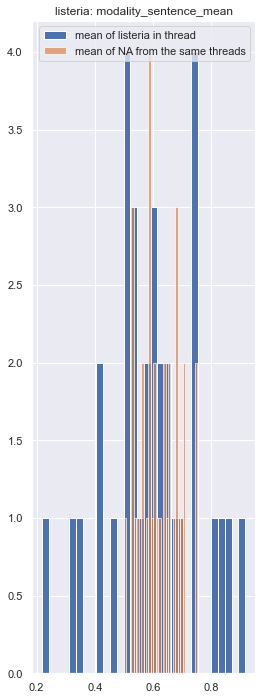

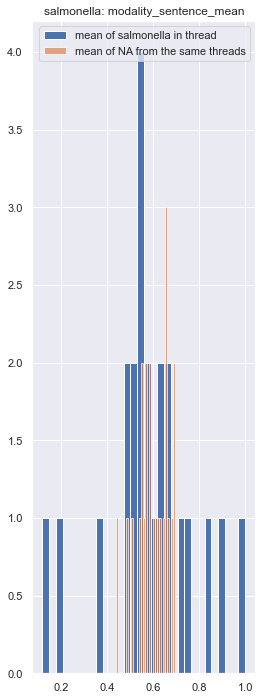

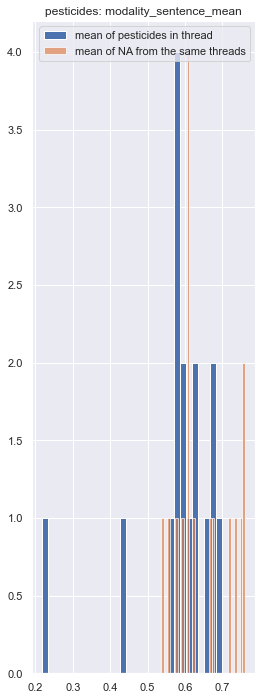

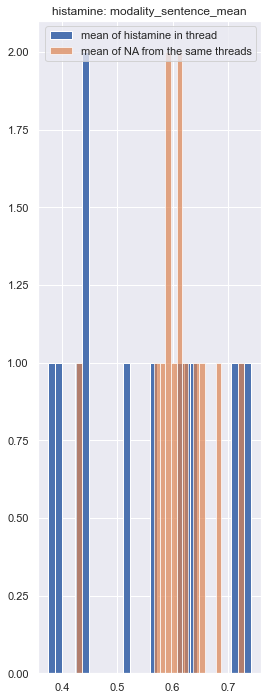

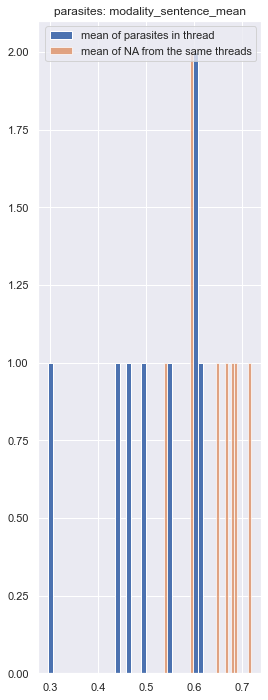

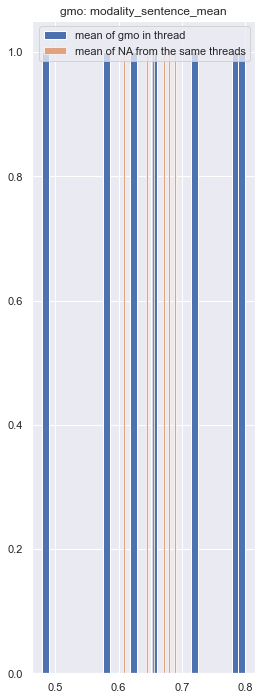

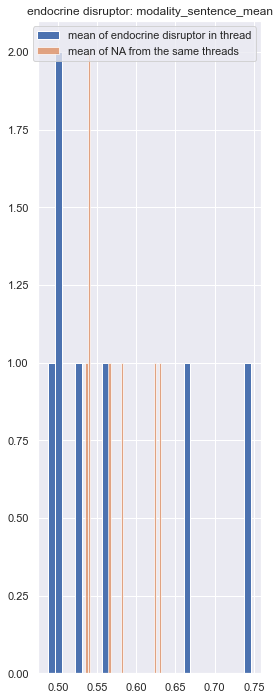

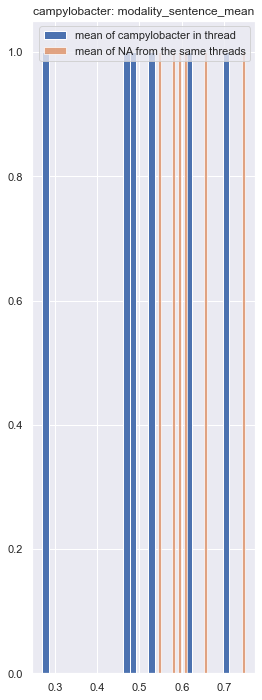

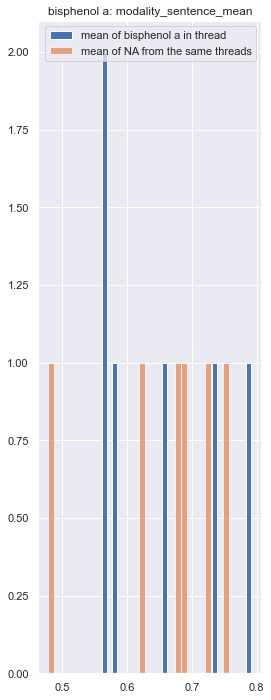

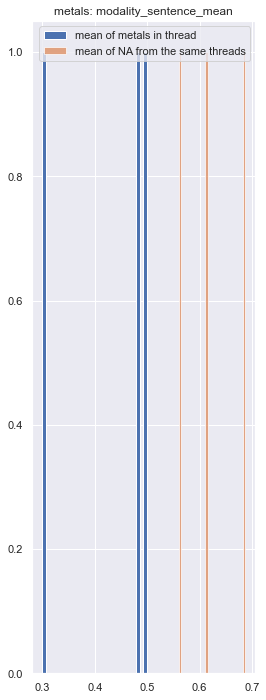

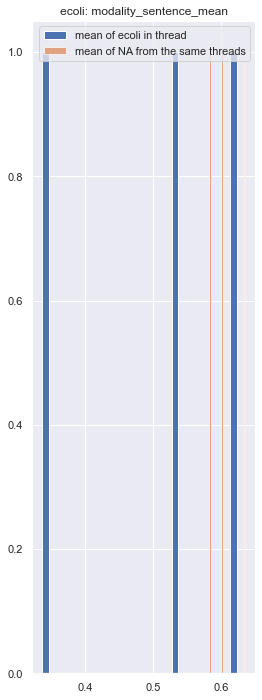

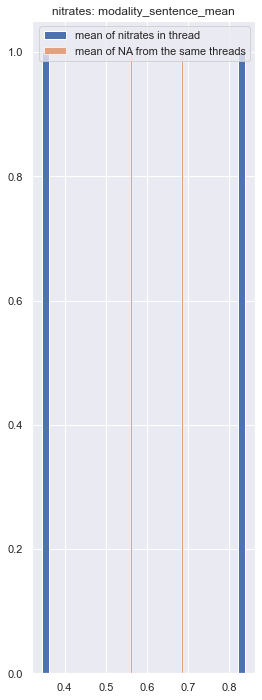

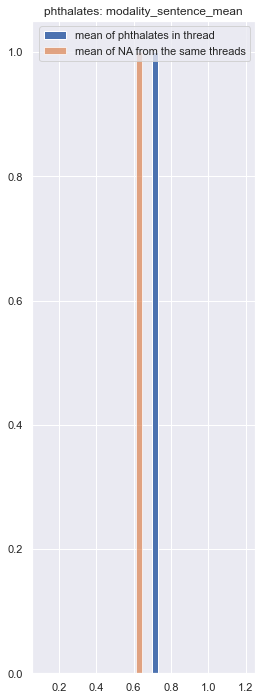

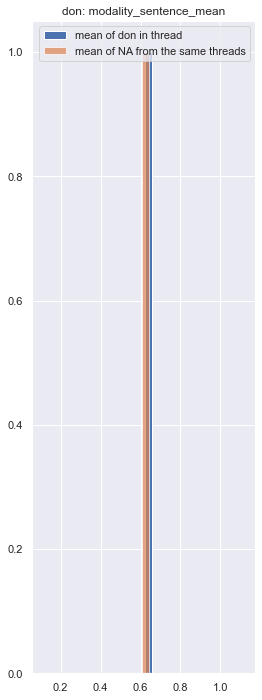

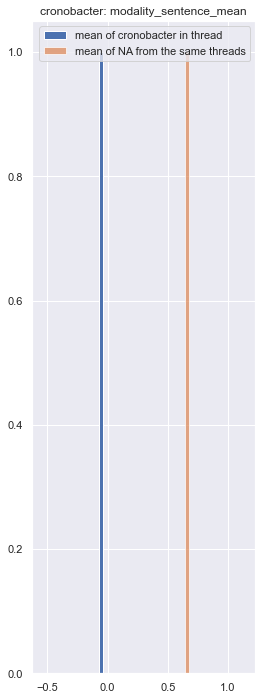

In [89]:
#check that the data are normally distributed
sns.set(rc={'figure.figsize':(5,4)})
for label in paired_df['hazard_type'].value_counts().index.drop('NA'):
    plt.hist(paired_values[label][0]['modality_sentence_mean'], bins=30)
    plt.hist(paired_values[label][1]['modality_sentence_mean'], bins = 30, alpha=0.7)
    plt.title('%s: modality_sentence_mean' % label)
    plt.legend(['mean of %s in thread' % label ,'mean of NA from the same threads'])
    plt.show()

#### F Test

In [90]:
F_Test = {item:np.var(class_df.loc[class_df['hazard_type'] == item]['modality_sentence_mean']) \
          for item in hazard_classes}

#One-Sided F-Test
#remove zero-variance elements.
F_Test = {key: baseline_v / item for key, item in F_Test.items() if item > 0}

#Make it Two-Sided
#remove zero-variance elements.
F_Test = {key: max(value, 1./value) for key, value in F_Test.items() if value > 0}

#define rejection level
alpha = 0.05

#Test against the F distirbution at the given level
F_Test = {key:scipy.stats.f.cdf(F, m - 1, n[key]-1) for key, F in F_Test.items()}
F_Test = {key:{'Reject H0':p>1-(alpha/2),'p':p } for key, p in F_Test.items()}

In [91]:
#show results
pd.DataFrame(F_Test).transpose()

Reject H0         p
other bacteria                                    True  0.999911
related terms                                     True  0.999965
food preservatives, sweeteners and additives      True         1
microbiologic contaminants                        True  0.999977
virus                                             True         1
bisphenol a                                       True  0.999283
listeria                                         False  0.875511
salmonella                                       False  0.658293
pesticides                                        True  0.999347
histamine                                         True  0.989631
parasites                                         True  0.982474
gmo                                               True  0.982584
campylobacter                                    False  0.861422
endocrine disruptor                               True  0.984907
metals                                           False   0.84749
ecoli                                            False  0.751203
nitrates                                         False  0.367366

#### Paired T-Test

In [92]:
T_Test = get_paired_t_tests(paired_values, 'modality_sentence_mean')
display_t_test()

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Number of Occurences of Hazard Term by Category

Here, we examine the number of occurences in a post, with the goal of performing regressions between our metrics and the number of occurences in a post. Of course, if the number of occurences does not vary much then the regressions will be pointless

In [93]:
#assign the max to it's own col to graph easily
class_df['count_for_classified_hazard'] =class_df[hazards.keys()].max(axis=1)

<AxesSubplot:xlabel='count_for_classified_hazard', ylabel='hazard_type'>

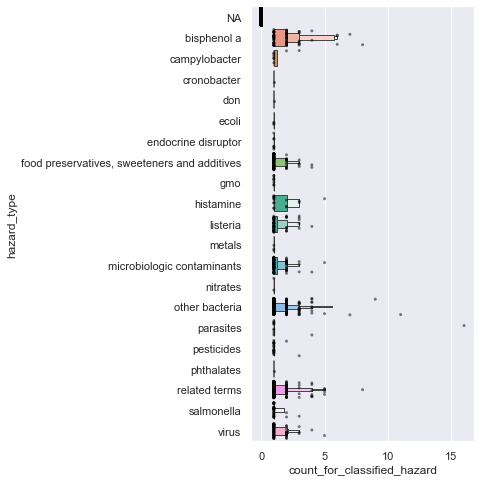

In [94]:
sns.set(rc={'figure.figsize':(4,8)})
sns.boxenplot(x='count_for_classified_hazard', y='hazard_type', data=class_df, k_depth='trustworthy', showfliers=False)
sns.stripplot(x='count_for_classified_hazard', y='hazard_type', data=class_df, color='black', alpha=0.5, jitter=0.4, size=3)

# Regressions

In [95]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
#https://www.statsmodels.org/devel/index.html

In [96]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

In [97]:
X = np.array(class_df.loc[class_df['hazard_type'] != 'NA']['count_for_classified_hazard'])
y = class_df.loc[class_df['hazard_type'] != 'NA']['sentiment']

#skelarn implementation, I went with sm instead , its better.
#X of shape shape (n_samples, n_features)
#y of shape shape (n_samples,) or (n_samples, n_targets)
#reg = linear_model.LinearRegression().fit(X.reshape(-1,1), y)
#(reg.score(X.reshape(-1,1), y), reg.coef_ , reg.intercept_)

We get higher coefficient and lower intercept but obviosuly this is because the NA data has a 7000 subset of points with sentiment at zero.

## Interaction Modeled Regression: 
    * using hazard as category
    * using product as category
    
Regression Specification (todo):


$Y = \beta_0 + \bf{\beta} \mathbb{1}_{posthazrd category}\bf{X}$

So $\mathbb{1}$ is a factor variable splitting the counts of *all* hazards based on the hazard categroy determined

for this specification we do not need to drop NA because they are already separated and ran only by the factor vairable NA

In [98]:
X = class_df[list(hazards.keys()) + ['hazard_type', 'sentiment']]
X.columns = make_underscores(list(X.columns)) #for easy use with smf.
X.columns = [re.sub(',','',i) for i in X.columns] #for easy use with smf.

#https://www.statsmodels.org/stable/example_formulas.html#categorical-variables

regressors = list(X.columns.drop('hazard_type')) #this works because list.drop is not in place!
fmla = 'sentiment ~ (%s) : hazard_type' % ' + '.join(regressors)

results = smf.ols(formula=fmla, data=X, missing='drop').fit()
print(fmla)
print(results.summary())

sentiment ~ (chemical_contaminants + endocrine_disruptor + food_preservatives_sweeteners_and_additives + pesticides + veterinary_drugs + gmo + metals + mycotoxin + bisphenol_a + furan + don + dioxin_and_pcb + mosh_and_moah + nitrates + acrylamid + phthalates + microbiologic_contaminants + salmonella + campylobacter + listeria + ecoli + cronobacter + histamine + other_bacteria + virus + parasites + related_terms + sentiment) : hazard_type
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.142e+30
Date:                Tue, 27 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:10:02   Log-Likelihood:             6.4971e+05
No. Observations:               19671   AIC:                        -1.299e+06
Df Re

In [99]:
#the SAME THING buy by products!
X = class_df[list(hazards.keys()) + ['product_type', 'sentiment']]
X.columns = make_underscores(list(X.columns)) #for easy use with smf.
X.columns = [re.sub(',','',i) for i in X.columns] #for easy use with smf.

#https://www.statsmodels.org/stable/example_formulas.html#categorical-variables

regressors = list(X.columns.drop('product_type')) #this works because list.drop is not in place!
fmla = 'sentiment ~ (%s) : product_type' % ' + '.join(regressors)

results = smf.ols(formula=fmla, data=X, missing='drop').fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.909e+30
Date:                Tue, 27 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:10:04   Log-Likelihood:             6.4745e+05
No. Observations:               19671   AIC:                        -1.295e+06
Df Residuals:                   19591   BIC:                        -1.294e+06
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

## Simpler Models
* fewer coefficients & easier to interpret
* higher conf levels

### Pattern Sentiment

In [100]:
#all hazard vars at once.
X = class_df.loc[class_df['hazard_type'] != 'NA'][hazards.keys()]
y = class_df.loc[class_df['hazard_type'] != 'NA']['sentiment']
X=sm.add_constant(X)
results = sm.OLS(y,X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.697
Date:                Tue, 27 Jul 2021   Prob (F-statistic):             0.0256
Time:                        16:10:04   Log-Likelihood:                 516.42
No. Observations:                1180   AIC:                            -988.8
Df Residuals:                    1158   BIC:                            -877.2
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [101]:
# TODO: ! There are multicollinearity problems possibly. How to fix? Why?

### NLTK Sentiment

In [102]:
#all hazard vars at once.
X = class_df.loc[class_df['hazard_type'] != 'NA'][hazards.keys()]
y = class_df.loc[class_df['hazard_type'] != 'NA']['nltk_compound_mean']
X=sm.add_constant(X)
results = sm.OLS(y,X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     nltk_compound_mean   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     5.126
Date:                Tue, 27 Jul 2021   Prob (F-statistic):           6.17e-13
Time:                        16:10:04   Log-Likelihood:                -87.598
No. Observations:                1180   AIC:                             219.2
Df Residuals:                    1158   BIC:                             330.8
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

We remove NA because these posts do not contain any mentions of hazards. They add unnecessary noise because their sentiments may vary due to other non-observed factors.

Significance at 5% level: 

* Positive: Bisphenol A, Pthalates
* Negative : Listeria, Cronobacter, Virus, Related Terms

### Subjectivity

In [103]:
X = class_df.loc[class_df['hazard_type'] != 'NA'][hazards.keys()]
y = class_df.loc[class_df['hazard_type'] != 'NA']['subjectivity']
X=sm.add_constant(X)
results = sm.OLS(y,X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           subjectivity   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     3.141
Date:                Tue, 27 Jul 2021   Prob (F-statistic):           2.45e-06
Time:                        16:10:05   Log-Likelihood:                 264.86
No. Observations:                1180   AIC:                            -485.7
Df Residuals:                    1158   BIC:                            -374.1
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------


Significance at 5% level: 

* Positive: Bisphenol A
* Negative : chemical contaminants, campylobacter, related terms

### Modality (how sure the person sounds)

In [104]:
X = class_df.loc[class_df['hazard_type'] != 'NA'][hazards.keys()]
y = class_df.loc[class_df['hazard_type'] != 'NA']['modality_sentence_mean']
X=sm.add_constant(X)
results = sm.OLS(y,X).fit()
print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     modality_sentence_mean   R-squared:                       0.031
Model:                                OLS   Adj. R-squared:                  0.013
Method:                     Least Squares   F-statistic:                     1.767
Date:                    Tue, 27 Jul 2021   Prob (F-statistic):             0.0176
Time:                            16:10:05   Log-Likelihood:                 376.73
No. Observations:                    1180   AIC:                            -709.5
Df Residuals:                        1158   BIC:                            -597.9
Df Model:                              21                                         
Covariance Type:                nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------


Significance at 5% level: 

* Positive: mycotoxin, bisphenol a, mosh and moah, acrylamid, microbiologic contaminants
* Negative : chemical contaminants, cronobacter

## Simple Model with "Controls"
* same spec as simple model but also has the count terms from countvecotrizer without tf-idf

* WHY??
 * The only good reason to add these terms to our regression is to function as a CONTROL.
 	* The terms should not be terms which on their own are strong sentiment indicators.
 * Other than this, it is better to use the terms in the context of checking for CORRELATION.
 	* If they are heavily correlated and not strong sentiment-indicating words, we should/can add to the regression as controls.


In [131]:
#remove duplicate column names
other_words = list(set(maxcountdf.columns) - set(class_df.columns))
#create concat df
temp_df = pd.concat([class_df,maxcountdf[other_words]], axis=1)
cols = list(hazards.keys()) + other_words

In [ ]:
#all hazard vars at once.
X = temp_df.loc[temp_df['hazard_type'] != 'NA'][cols]
X=sm.add_constant(X)

### Pattern Sentiment 

In [ ]:
y = temp_df.loc[temp_df['hazard_type'] != 'NA']['sentiment']
results = sm.OLS(y,X).fit()
print(results.summary())

### NLTK Sentiment

In [135]:
y = class_df.loc[class_df['hazard_type'] != 'NA']['nltk_compound_mean']
results = sm.OLS(y,X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     nltk_compound_mean   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     3.332
Date:                Tue, 27 Jul 2021   Prob (F-statistic):           5.51e-25
Time:                        17:09:17   Log-Likelihood:                 44.437
No. Observations:                1180   AIC:                             147.1
Df Residuals:                    1062   BIC:                             745.8
Df Model:                         117                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

### Subjectivity

In [136]:
y = class_df.loc[class_df['hazard_type'] != 'NA']['subjectivity']
results = sm.OLS(y,X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           subjectivity   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     2.602
Date:                Tue, 27 Jul 2021   Prob (F-statistic):           1.29e-15
Time:                        17:09:35   Log-Likelihood:                 380.90
No. Observations:                1180   AIC:                            -525.8
Df Residuals:                    1062   BIC:                             72.84
Df Model:                         117                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

### Modality (how sure the person sounds)

In [137]:
y = class_df.loc[class_df['hazard_type'] != 'NA']['modality_sentence_mean']
results = sm.OLS(y,X).fit()
print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     modality_sentence_mean   R-squared:                       0.158
Model:                                OLS   Adj. R-squared:                  0.066
Method:                     Least Squares   F-statistic:                     1.709
Date:                    Tue, 27 Jul 2021   Prob (F-statistic):           1.26e-05
Time:                            17:09:46   Log-Likelihood:                 459.91
No. Observations:                    1180   AIC:                            -683.8
Df Residuals:                        1062   BIC:                            -85.17
Df Model:                             117                                         
Covariance Type:                nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

## Regression by Sentence:
* specification (WIP):

# TEMP expanding our count thing to do it by indiviudal sentence.

# Location of Mention of Hazards within Threads

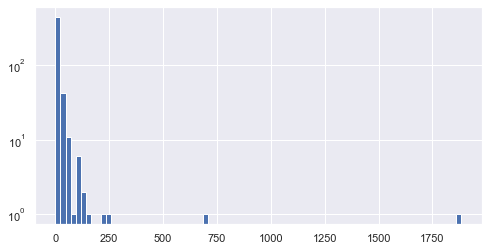

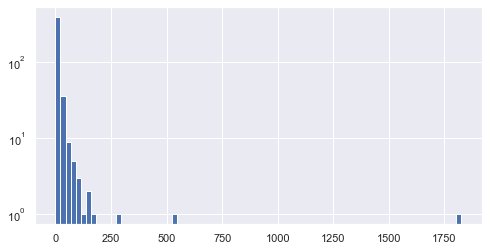

In [105]:
# the average placement of post in thread.
NA_group = class_df.loc[class_df['hazard_type'] == 'NA'].reset_index().groupby('level_0')
hazard_grouped_df = class_df.loc[class_df['hazard_type'] != 'NA'].reset_index().groupby('level_0')

sns.set(rc={'figure.figsize':(8,4)})
plt.hist(NA_group['level_1'].mean(), log=True, bins=80)
plt.show()
plt.hist(hazard_grouped_df['level_1'].mean(), log=True, bins = 80)
plt.show()

#this is misleading, we need to group by thread and take averages again. I can use teh code I already did for the paired t-test! 

<AxesSubplot:ylabel='Frequency'>

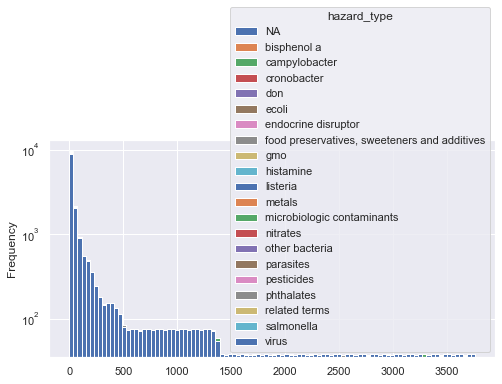

In [106]:
class_df.reset_index().pivot(columns='hazard_type').level_1.plot(kind = 'hist', stacked=True, log=True, bins=100)

<AxesSubplot:ylabel='Frequency'>

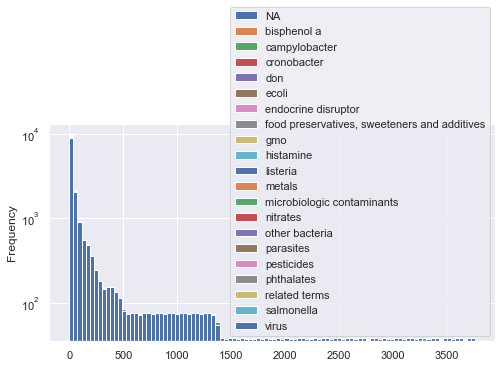

In [107]:
pd.DataFrame({k: v for k, v in class_df.reset_index().groupby('hazard_type').level_1}).plot.hist(stacked=True, log=True, bins=100)

We can see from the above that we have three distinct levels of data: (0,500), (500,1500), (1500, inf)

We can plot these separately to get a better look.

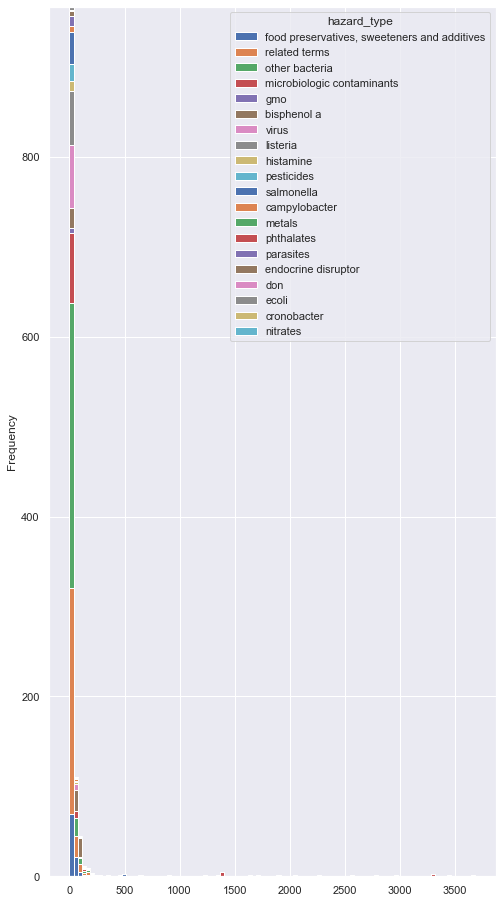

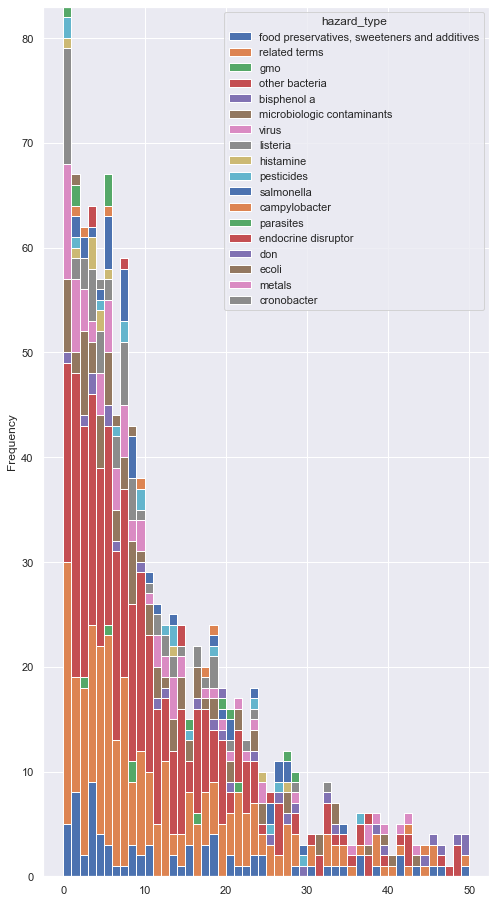

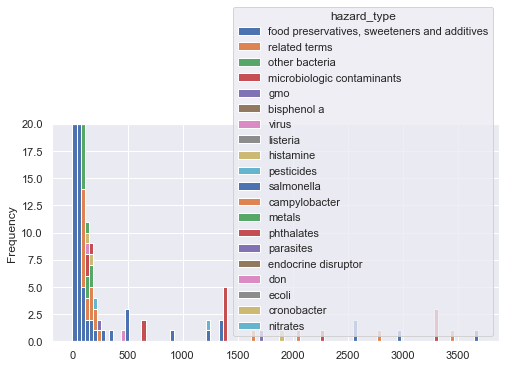

In [108]:
#entire thing
sns.set(rc={'figure.figsize':(8,16)})
class_df.loc[class_df['hazard_type'] != 'NA'].reset_index().pivot(columns='hazard_type').level_1.plot(kind = 'hist', stacked=True, bins=100)
plt.show()

#only early posts
temp_df = class_df.loc[class_df['hazard_type'] != 'NA'].reset_index()
temp_df = temp_df.loc[temp_df['level_1'] <= 50]
sns.set(rc={'figure.figsize':(8,16)})
temp_df.pivot(columns='hazard_type').level_1.plot(kind = 'hist', stacked=True, bins=50)
plt.show()

#further out, fewer of these
sns.set(rc={'figure.figsize':(8,4)})
class_df.loc[class_df['hazard_type'] != 'NA'].reset_index().pivot(columns='hazard_type').level_1.plot(kind = 'hist', stacked=True, bins=100, ylim=(0,20))
plt.show()

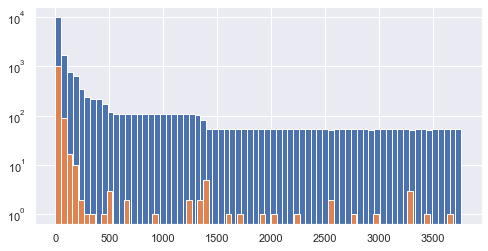

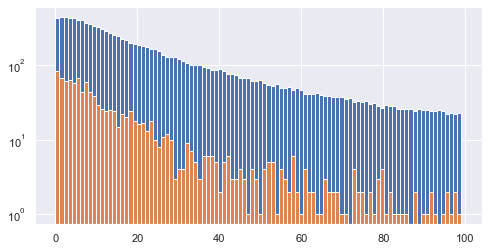

In [109]:
#all occurences, not averaged
sns.set(rc={'figure.figsize':(8,4)})
plt.hist(class_df.loc[class_df['hazard_type'] == 'NA'].reset_index()['level_1'], bins=70, log=True, histtype='barstacked')
plt.hist(class_df.loc[class_df['hazard_type'] != 'NA'].reset_index()['level_1'], bins=70, log=True, histtype='barstacked')
plt.show()

#with xlimit
sns.set(rc={'figure.figsize':(8,4)})
temp_df = class_df.reset_index()
temp_df = temp_df.loc[temp_df['level_1'] <= 99]
plt.hist(temp_df.loc[temp_df['hazard_type'] == 'NA']['level_1'], bins=100, log=True)
plt.hist(temp_df.loc[temp_df['hazard_type'] != 'NA']['level_1'], bins=100, log=True)
plt.show()

In [110]:
temp_group.loc[temp_group['hazard_type'] == NA]

NameError: name 'temp_group' is not defined

In [ ]:
class_df[product_cols].corr()

# Examine URLS and quotes from hazard posts

In [ ]:
#TODO: get mre specific, which product is it classified as? what thread is it in, etc things.

In [ ]:
hazard_post_keys = class_df.loc[class_df['hazard_type'] != 'NA'].index

In [ ]:
len(hazard_post_keys)

In [ ]:
all_links = []
all_quotes = []
for key in hazard_post_keys:
    all_links.append(posts_dict[key]['body_urls'])
for key in hazard_post_keys:
    all_quotes.append(posts_dict[key]['quotes_w'])
for key in hazard_post_keys:
    all_quotes.append(posts_dict[key]['quotes_y'])

In [ ]:
#flatten
all_links = [link for item in all_links for link in item]
all_quotes = [quote for item in all_quotes for quote in item]

In [ ]:
y_quotes = [quote for quote in all_quotes if type(quote) is dict]

In [ ]:
pd.Series([i['name'] for i in y_quotes]).value_counts()

In [ ]:
#TODO: most common words or something

In [ ]:
dict(pd.DataFrame(all_links).value_counts())

In [ ]:
#look to see if hazard mentioning posts were quotes by NA posts.
na_quotes =[]
for key in hazard_post_keys:
    na_quotes.append(posts_dict[key]['quotes_w'])
for key in hazard_post_keys:
    if posts_dict[key]['quotes_y']:
        na_quotes.append({i['text'] for i in posts_dict[key]['quotes_y']) #TODO: alternate way {text, quotes} and analyze the relationship between words and replies to it
#flatten
na_quotes = [quote for item in na_quotes for quote in item]

In [ ]:
na_quotes

In [ ]:
quote_counts = term_counter.fit_transform(na_quotes)

In [ ]:
quote_counts_arr = quote_counts.toarray() #run once
quote_counts_list = []

In [ ]:
for num, _ in enumerate(quote_counts_arr): #TODO just use netmums, not text_dict?? its confusing. (they have the same keys)
    quote_counts_list.append({term: quote_counts_arr[num][value] for term, value in term_counter.vocabulary_.items()})

In [ ]:
quotecountdf = pd.DataFrame.from_dict(quote_counts_list)
quotecountdf
#TODO:combine columns

In [ ]:
sns.set(rc={'figure.figsize':(5,25)})
plt.barh(quotecountdf.sum(axis=0).index, quotecountdf.sum(axis=0), log=True)
plt.show()